In [904]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import hockey_rink
import hockey_scraper
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math

Gonna get familiar with hockey_scraper, never used it until now. Scraping the schedule between 2023-09-01 and 2024-08-31. Should be 1,312 NHL games in a season.

In [ ]:
hockey_scraper.scrape_seasons([2023,2024], True)

Noe have shift data for the nhl 2023-24 season as well as the play by play data (pbp) in separate csv files. 

In [905]:
#Loading in pbp data
pbp=pd.read_csv("nhl_pbp_20232024.csv")

How many rows in our dataframe total?
-445,637 rows before we do any type of manipulation or cleaning
-After dropping rows that contain na values for x and y locations, we have 323,164 rows
-

In [906]:
pbp.info()
#445,637 events worth of data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445637 entries, 0 to 445636
Data columns (total 57 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Unnamed: 0       445637 non-null  int64  
 1   Game_Id          445637 non-null  int64  
 2   Date             445637 non-null  object 
 3   Period           445637 non-null  int64  
 4   Event            445637 non-null  object 
 5   Description      445637 non-null  object 
 6   Time_Elapsed     445637 non-null  object 
 7   Seconds_Elapsed  445637 non-null  float64
 8   Strength         445637 non-null  object 
 9   Ev_Zone          369193 non-null  object 
 10  Type             180765 non-null  object 
 11  Ev_Team          369085 non-null  object 
 12  Home_Zone        369193 non-null  object 
 13  Away_Team        445637 non-null  object 
 14  Home_Team        445637 non-null  object 
 15  p1_name          369011 non-null  object 
 16  p1_ID            360845 non-null  floa

In [907]:
# Drop rows where xC or yC is NaN
pbp = pbp.dropna(subset=['xC', 'yC'])
pbp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 323164 entries, 1 to 445636
Data columns (total 57 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Unnamed: 0       323164 non-null  int64  
 1   Game_Id          323164 non-null  int64  
 2   Date             323164 non-null  object 
 3   Period           323164 non-null  int64  
 4   Event            323164 non-null  object 
 5   Description      323164 non-null  object 
 6   Time_Elapsed     323164 non-null  object 
 7   Seconds_Elapsed  323164 non-null  float64
 8   Strength         323164 non-null  object 
 9   Ev_Zone          270144 non-null  object 
 10  Type             139605 non-null  object 
 11  Ev_Team          270069 non-null  object 
 12  Home_Zone        270144 non-null  object 
 13  Away_Team        323164 non-null  object 
 14  Home_Team        323164 non-null  object 
 15  p1_name          270001 non-null  object 
 16  p1_ID            263648 non-null  float64
 

Step 2: Data Cleansing

Definitely do not need many of these variables so going to drop a bunch of them

In [908]:
pbp[['awayPlayer1','awayPlayer2', 'awayPlayer3','awayPlayer4','awayPlayer5','awayPlayer6']].head(10)

,awayPlayer1,awayPlayer2,awayPlayer3,awayPlayer4,awayPlayer5,awayPlayer6
1,JUUSO PARSSINEN,RYAN O'REILLY,FILIP FORSBERG,RYAN MCDONAGH,ALEXANDRE CARRIER,JUUSE SAROS
2,YAKOV TRENIN,RYAN O'REILLY,COLE SMITH,LUKE SCHENN,ROMAN JOSI,JUUSE SAROS
4,COLTON SISSONS,YAKOV TRENIN,COLE SMITH,LUKE SCHENN,ROMAN JOSI,JUUSE SAROS
5,COLTON SISSONS,YAKOV TRENIN,COLE SMITH,LUKE SCHENN,ROMAN JOSI,JUUSE SAROS
6,COLTON SISSONS,YAKOV TRENIN,COLE SMITH,LUKE SCHENN,ROMAN JOSI,JUUSE SAROS
7,COLTON SISSONS,YAKOV TRENIN,COLE SMITH,LUKE SCHENN,ROMAN JOSI,JUUSE SAROS
8,CODY GLASS,GUSTAV NYQUIST,KIEFER SHERWOOD,JEREMY LAUZON,TYSON BARRIE,JUUSE SAROS
9,CODY GLASS,GUSTAV NYQUIST,KIEFER SHERWOOD,JEREMY LAUZON,TYSON BARRIE,JUUSE SAROS
10,CODY GLASS,GUSTAV NYQUIST,KIEFER SHERWOOD,JEREMY LAUZON,TYSON BARRIE,JUUSE SAROS
11,CODY GLASS,GUSTAV NYQUIST,KIEFER SHERWOOD,JEREMY LAUZON,TYSON BARRIE,JUUSE SAROS


Alright looks like players 1,2, and 3 are the forwards. 4 and 5 are the defensemen and 6 is the goalie, So i only need players 1-3

In [909]:
pbp=pbp.drop(['Away_Coach','Home_Coach','Home_Goalie_Id','Home_Goalie','Away_Goalie_Id','Away_Goalie', 'Unnamed: 0','awayPlayer4','awayPlayer4_id','awayPlayer5','awayPlayer5_id','awayPlayer6','awayPlayer6_id','homePlayer4','homePlayer4_id','homePlayer5','homePlayer5_id','homePlayer6','homePlayer6_id'], axis=1)

In [910]:
pbp.Type.value_counts()

Type
WRIST SHOT                              77163
SNAP SHOT                               18419
SLAP SHOT                               16066
TIP-IN                                   9190
BACKHAND                                 8148
                                        ...  
AR #77 DEANGELO Slashing(2 min)             1
OS #61 MAROON High-sticking(2 min)          1
AL #3 TANEV Delay Game(2 min)               1
AL #3 TANEV High-sticking(2 min)            1
YR #96 ROSLOVIC High-sticking(2 min)        1
Name: count, Length: 204, dtype: int64

Got rid of a ton of columns not needed. All columns now should be useful

In [911]:
pbp.columns

Index(['Game_Id', 'Date', 'Period', 'Event', 'Description', 'Time_Elapsed',
       'Seconds_Elapsed', 'Strength', 'Ev_Zone', 'Type', 'Ev_Team',
       'Home_Zone', 'Away_Team', 'Home_Team', 'p1_name', 'p1_ID', 'p2_name',
       'p2_ID', 'p3_name', 'p3_ID', 'awayPlayer1', 'awayPlayer1_id',
       'awayPlayer2', 'awayPlayer2_id', 'awayPlayer3', 'awayPlayer3_id',
       'homePlayer1', 'homePlayer1_id', 'homePlayer2', 'homePlayer2_id',
       'homePlayer3', 'homePlayer3_id', 'Away_Players', 'Home_Players',
       'Away_Score', 'Home_Score', 'xC', 'yC'],
      dtype='object')

Variables we want, many of which need to be modified or created:

    1)xC (modified) (Done)

    2)yC (Modified) (Done)

    3)Type (modified) (Done)

    4)shotDistance (Create)

    5)shotAngle (Create)

    6)timeSinceLastEvent (Create) (Done)

    7)distanceFromLastEvent (Create) (Have to calculate before transposing the x and y coordinates, cuz what if back to back shots happen between the two teams?) (Done)

    8)PowerPlay (Create) (Done)

    9) Goal (Create) - TARGET VARIABLE (Done)

-Date needs to be last of reg season, not last of entire season including playoffs

Calculating the distanceFromLastEvent prior to transposing x and y coordinates

In [912]:
# Calculate the difference in x and y coordinates between consecutive events
pbp['x_diff'] = pbp['xC'].diff()
pbp['y_diff'] = pbp['yC'].diff()

# Calculate the Euclidean distance between consecutive events
pbp['distanceFromLastEvent'] = np.sqrt(pbp['x_diff']**2 + pbp['y_diff']**2)

# Fill NaN values that may result from the first row
pbp['distanceFromLastEvent'] = pbp['distanceFromLastEvent'].fillna(0)

# Optionally, drop the intermediate x_diff and y_diff columns if no longer needed
pbp = pbp.drop(columns=['x_diff', 'y_diff'])

Making all shots occur on the right side of the rink, modifying the xC and yC

In [913]:
#First making all shots appear on the positive (right side of the rink)
pbp['xC']=np.where(pbp['xC']<0, pbp['xC']*-1, pbp['xC'])
pbp['yC']=np.where(pbp['xC']<0, pbp['yC']*-1, pbp['yC'])

Making new column for PowerPlay, 1 means yes there is a pp and 0 means no pp

In [914]:
# Make a new column for whether or not its a power play goal. 
pbp['Power Play'] = np.where( ((pbp.Ev_Team.equals(pbp.Home_Team)) & (pbp.Strength.str[0] > pbp.Strength.str[2])) | ((pbp.Ev_Team.equals(pbp.Away_Team)) & (pbp.Strength.str[0] < pbp.Strength.str[2])), 1, 0)

Getting time since last event (Right now have seconds elapsed, which is just time elapsed from period. So to get time elapsed since last event, Just have to subtract seconds elased on previous row/event from the current row/event)

In [915]:
pbp['timeSinceLastEvent']= pbp['Seconds_Elapsed'].diff()
pbp['timeSinceLastEvent'] = pbp['timeSinceLastEvent'].fillna(0)


Make the each shot type into individual binary value columns using one hot encoding (Then keeping the columns created that represents shots only: WRIST SHOT,SNAP SHOT,SLAP SHOT,TIP-IN,BACKHAND, Done at the very end of data cleaning)

In [916]:
dtype = pbp['Type'].dtype
print(dtype)

object


In [917]:
pbp['Type'].value_counts()

Type
WRIST SHOT                              77163
SNAP SHOT                               18419
SLAP SHOT                               16066
TIP-IN                                   9190
BACKHAND                                 8148
                                        ...  
AR #77 DEANGELO Slashing(2 min)             1
OS #61 MAROON High-sticking(2 min)          1
AL #3 TANEV Delay Game(2 min)               1
AL #3 TANEV High-sticking(2 min)            1
YR #96 ROSLOVIC High-sticking(2 min)        1
Name: count, Length: 204, dtype: int64

Im going to keep only the values of type above not any other crazy ones. I am also going to convert to string.

In [918]:
pbp['Type'] = pbp['Type'].astype(str)
pbp=pbp[(pbp['Type']=='WRIST SHOT') | (pbp['Type']=='SNAP SHOT') | (pbp['Type']=='SLAP SHOT') | (pbp['Type']=='TIP-IN') | (pbp['Type']=='BACKHAND') | (pbp['Type']=='DEFLECTED') | (pbp['Type']=='WRAP-AROUND') ]

In [919]:
#checking 
pbp['Type'].value_counts()

Type
WRIST SHOT     77163
SNAP SHOT      18419
SLAP SHOT      16066
TIP-IN          9190
BACKHAND        8148
DEFLECTED       2074
WRAP-AROUND      919
Name: count, dtype: int64

In [920]:
# Ensure the Type column is clean (e.g., no leading/trailing spaces)
pbp['Type'] = pbp['Type'].str.strip()

# Identify unique categories
unique_types = pbp['Type'].unique()

# Manually one-hot encode
for shot_type in unique_types:
    pbp[shot_type] = (pbp['Type'] == shot_type).astype(int)

Code below for ohe not working, trying the above approach instead

In [344]:
# #First step load in one hot encoder from the sklearn.preprocessing library
# from sklearn.preprocessing import OneHotEncoder
# # Ensure there are no NaNs in the 'Type' column
# pbp = pbp.dropna(subset=['Type'])
# #Second step is to initialize OneHotEncoder
# ohe=OneHotEncoder(sparse_output=False, drop='first')
# #Third step is to fit and transform
# pbp_ohe=ohe.fit_transform(pbp[['Type']])
# #Fourth step is to conver the output to a datafram with the appropriate column names
# pbp_df_ohe=pd.DataFrame(pbp_ohe, columns=ohe.get_feature_names_out(['Type']))
# #Fifth step is to combine the encoded shotType columns with the original dataframe
# pbp=pd.concat([pbp, pbp_df_ohe], axis=1)

In [345]:
# print(ohe.get_feature_names_out(['Type']))

['Type_DEFLECTED' 'Type_SLAP SHOT' 'Type_SNAP SHOT' 'Type_TIP-IN'
 'Type_WRAP-AROUND' 'Type_WRIST SHOT']


In [921]:
#Checking columns
pbp.columns

Index(['Game_Id', 'Date', 'Period', 'Event', 'Description', 'Time_Elapsed',
       'Seconds_Elapsed', 'Strength', 'Ev_Zone', 'Type', 'Ev_Team',
       'Home_Zone', 'Away_Team', 'Home_Team', 'p1_name', 'p1_ID', 'p2_name',
       'p2_ID', 'p3_name', 'p3_ID', 'awayPlayer1', 'awayPlayer1_id',
       'awayPlayer2', 'awayPlayer2_id', 'awayPlayer3', 'awayPlayer3_id',
       'homePlayer1', 'homePlayer1_id', 'homePlayer2', 'homePlayer2_id',
       'homePlayer3', 'homePlayer3_id', 'Away_Players', 'Home_Players',
       'Away_Score', 'Home_Score', 'xC', 'yC', 'distanceFromLastEvent',
       'Power Play', 'timeSinceLastEvent', 'WRIST SHOT', 'TIP-IN', 'SNAP SHOT',
       'SLAP SHOT', 'BACKHAND', 'DEFLECTED', 'WRAP-AROUND'],
      dtype='object')

Dropping shots from behind the net

In [922]:
pbp.drop(pbp[pbp['xC'] > 89].index, inplace=True)

Getting goals column

In [923]:
# Add a binary column for Goals 
pbp['goal'] = np.where(pbp.Event == 'GOAL', 1, 0)

In [924]:
pbp['goal'].value_counts()

goal
0    114067
1      6846
Name: count, dtype: int64

In [925]:
pbp['Event'].value_counts()

Event
SHOT     59390
BLOCK    30792
MISS     23885
GOAL      6846
Name: count, dtype: int64

We can drop all rows where event is not equal to shot or goal because we already calculated the distance from last event and the time since last event which were the variables that needed to have every event in the dataframe. 

In [926]:
pbp=pbp[(pbp['Event']=='SHOT') | (pbp['Event']=='GOAL') | (pbp['Event']=='MISS')]

In [927]:
#Seeing the pbp dataframe
pbp[['Ev_Zone','Ev_Team','Home_Team','Away_Team','Event', 'awayPlayer1','awayPlayer2','awayPlayer3','homePlayer1','homePlayer2','homePlayer3','Description','Strength', 'Seconds_Elapsed', 'timeSinceLastEvent','goal','distanceFromLastEvent','Power Play','xC','yC']].head(10)

,Ev_Zone,Ev_Team,Home_Team,Away_Team,Event,awayPlayer1,awayPlayer2,awayPlayer3,homePlayer1,homePlayer2,homePlayer3,Description,Strength,Seconds_Elapsed,timeSinceLastEvent,goal,distanceFromLastEvent,Power Play,xC,yC
6,Off,T.B,T.B,NSH,SHOT,COLTON SISSONS,YAKOV TRENIN,COLE SMITH,BRAYDEN POINT,STEVEN STAMKOS,NIKITA KUCHEROV,"TBL ONGOAL - #43 RADDYSH, Wrist , Off. Zone, 3...",5x5,61.0,3.0,0,26.019224,0,44.0,-38.0
40,Off,T.B,T.B,NSH,SHOT,PHILIP TOMASINO,RYAN O'REILLY,LUKE EVANGELISTA,BRAYDEN POINT,STEVEN STAMKOS,NIKITA KUCHEROV,"TBL ONGOAL - #77 HEDMAN, Wrist , Off. Zone, 63...",5x5,564.0,4.0,0,56.142675,0,55.0,30.0
41,Off,T.B,T.B,NSH,GOAL,JUUSO PARSSINEN,RYAN O'REILLY,FILIP FORSBERG,BRAYDEN POINT,STEVEN STAMKOS,NIKITA KUCHEROV,"TBL #86 KUCHEROV(1), Slap , Off. Zone, 42 ft.A...",5x5,588.0,24.0,1,119.067208,0,64.0,34.0
44,Neu,T.B,T.B,NSH,MISS,JUUSO PARSSINEN,RYAN O'REILLY,FILIP FORSBERG,TYLER MOTTE,ANTHONY CIRELLI,BRANDON HAGEL,"TBL #64 MOTTE, Wrist, Wide Right, Neu. Zone, 8...",5x5,603.0,15.0,0,72.422372,0,69.0,22.0
47,Off,T.B,T.B,NSH,SHOT,COLTON SISSONS,YAKOV TRENIN,COLE SMITH,LUKE GLENDENING,WALTTERI MERELA,TANNER JEANNOT,"TBL ONGOAL - #81 CERNAK, Snap , Off. Zone, 62 ...",5x5,615.0,9.0,0,50.009999,0,79.0,-27.0
49,Off,T.B,T.B,NSH,SHOT,COLTON SISSONS,YAKOV TRENIN,COLE SMITH,LUKE GLENDENING,WALTTERI MERELA,TANNER JEANNOT,"TBL ONGOAL - #11 GLENDENING, Wrist , Off. Zone...",5x5,637.0,19.0,0,68.883960,0,31.0,30.0
53,Off,T.B,T.B,NSH,SHOT,CODY GLASS,GUSTAV NYQUIST,KIEFER SHERWOOD,BRAYDEN POINT,STEVEN STAMKOS,NIKITA KUCHEROV,"TBL ONGOAL - #21 POINT, Wrist , Off. Zone, 15 ...",5x5,662.0,10.0,0,21.095023,0,69.0,-22.0
57,Off,T.B,T.B,NSH,SHOT,CODY GLASS,PHILIP TOMASINO,KIEFER SHERWOOD,MICHAEL EYSSIMONT,NICHOLAS PAUL,CONOR SHEARY,"TBL ONGOAL - #77 HEDMAN, Wrist , Off. Zone, 54...",5x5,693.0,23.0,0,77.278716,0,7.0,-36.0
61,Off,T.B,T.B,NSH,SHOT,JUUSO PARSSINEN,RYAN O'REILLY,FILIP FORSBERG,TYLER MOTTE,ANTHONY CIRELLI,BRANDON HAGEL,"TBL ONGOAL - #38 HAGEL, Snap , Off. Zone, 30 ft.",5x5,708.0,9.0,0,108.337436,0,69.0,-22.0
68,Off,T.B,T.B,NSH,MISS,GUSTAV NYQUIST,PHILIP TOMASINO,JUUSO PARSSINEN,WALTTERI MERELA,NICHOLAS PAUL,CALVIN DE HAAN,"TBL #20 PAUL, Snap, Wide Left, Off. Zone, 28 ft.",4x5,795.0,6.0,0,44.000000,0,69.0,-22.0


Ok, lets get a sense on where out dataframe is at, how many rows contain na values for the x and y coordinates?

In [928]:
# Count the number of NaN values in the xC and yC columns
xC_nan_count = pbp['xC'].isna().sum()
yC_nan_count = pbp['yC'].isna().sum()

# Print the counts
print(f"Number of NaN values in xC: {xC_nan_count}")
print(f"Number of NaN values in yC: {yC_nan_count}")

Number of NaN values in xC: 0
Number of NaN values in yC: 0


How many total values are in our dataframe?

In [929]:
pbp.shape

(90121, 49)

Getting shot angles using a function

In [930]:
# This function calculates the angle to the center of the net at (89, 0) in radians and degrees.
def angles(x, y):
    num = math.sqrt(((89.0 - x) * (89.0 - x)) + ((y) * (y)))
    if num==0:
        radians= 0.0
        degrees= 0.0
    else:
        radians = np.arcsin(y/num)
        degrees = (radians * 180.0) / 3.14
        
    arr = [radians, degrees]
    return arr

Now using that function to place angles into dataframe and also get shot distance

In [931]:
# Initiliaze empty columns
pbp['shotAngle_Radians'] = ''
pbp['shotAngle_Degrees'] = ''
pbp['shotDistance'] = ''

# Add values to columns 
for index, row in pbp.iterrows():
    x = row['xC']
    y = row['yC']
    all_angles = angles(x, y)
    pbp.at[index, 'shotAngle_Radians'] = all_angles[0]
    pbp.at[index, 'shotAngle_Degrees'] = all_angles[1]
    pbp.at[index, 'shotDistance'] = np.sqrt((y - 0)**2 + (x - 89.0)**2)

Now we should have all variables, lets see if it worked

In [932]:
pbp[['Ev_Zone','Ev_Team','Home_Team','Away_Team','Event', 'awayPlayer1','awayPlayer2','awayPlayer3','homePlayer1','homePlayer2','homePlayer3','Description','Strength', 'Seconds_Elapsed', 'timeSinceLastEvent','goal','distanceFromLastEvent','Power Play','xC','yC','shotAngle_Radians','shotAngle_Degrees','shotDistance']].head(10)

,Ev_Zone,Ev_Team,Home_Team,Away_Team,Event,awayPlayer1,awayPlayer2,awayPlayer3,homePlayer1,homePlayer2,homePlayer3,Description,Strength,Seconds_Elapsed,timeSinceLastEvent,goal,distanceFromLastEvent,Power Play,xC,yC,shotAngle_Radians,shotAngle_Degrees,shotDistance
6,Off,T.B,T.B,NSH,SHOT,COLTON SISSONS,YAKOV TRENIN,COLE SMITH,BRAYDEN POINT,STEVEN STAMKOS,NIKITA KUCHEROV,"TBL ONGOAL - #43 RADDYSH, Wrist , Off. Zone, 3...",5x5,61.0,3.0,0,26.019224,0,44.0,-38.0,-0.70126,-40.199613,58.898217
40,Off,T.B,T.B,NSH,SHOT,PHILIP TOMASINO,RYAN O'REILLY,LUKE EVANGELISTA,BRAYDEN POINT,STEVEN STAMKOS,NIKITA KUCHEROV,"TBL ONGOAL - #77 HEDMAN, Wrist , Off. Zone, 63...",5x5,564.0,4.0,0,56.142675,0,55.0,30.0,0.722979,41.444676,45.343136
41,Off,T.B,T.B,NSH,GOAL,JUUSO PARSSINEN,RYAN O'REILLY,FILIP FORSBERG,BRAYDEN POINT,STEVEN STAMKOS,NIKITA KUCHEROV,"TBL #86 KUCHEROV(1), Slap , Off. Zone, 42 ft.A...",5x5,588.0,24.0,1,119.067208,0,64.0,34.0,0.936774,53.700398,42.201896
44,Neu,T.B,T.B,NSH,MISS,JUUSO PARSSINEN,RYAN O'REILLY,FILIP FORSBERG,TYLER MOTTE,ANTHONY CIRELLI,BRANDON HAGEL,"TBL #64 MOTTE, Wrist, Wide Right, Neu. Zone, 8...",5x5,603.0,15.0,0,72.422372,0,69.0,22.0,0.832981,47.750518,29.732137
47,Off,T.B,T.B,NSH,SHOT,COLTON SISSONS,YAKOV TRENIN,COLE SMITH,LUKE GLENDENING,WALTTERI MERELA,TANNER JEANNOT,"TBL ONGOAL - #81 CERNAK, Snap , Off. Zone, 62 ...",5x5,615.0,9.0,0,50.009999,0,79.0,-27.0,-1.216091,-69.712204,28.79236
49,Off,T.B,T.B,NSH,SHOT,COLTON SISSONS,YAKOV TRENIN,COLE SMITH,LUKE GLENDENING,WALTTERI MERELA,TANNER JEANNOT,"TBL ONGOAL - #11 GLENDENING, Wrist , Off. Zone...",5x5,637.0,19.0,0,68.883960,0,31.0,30.0,0.477345,27.363748,65.299311
53,Off,T.B,T.B,NSH,SHOT,CODY GLASS,GUSTAV NYQUIST,KIEFER SHERWOOD,BRAYDEN POINT,STEVEN STAMKOS,NIKITA KUCHEROV,"TBL ONGOAL - #21 POINT, Wrist , Off. Zone, 15 ...",5x5,662.0,10.0,0,21.095023,0,69.0,-22.0,-0.832981,-47.750518,29.732137
57,Off,T.B,T.B,NSH,SHOT,CODY GLASS,PHILIP TOMASINO,KIEFER SHERWOOD,MICHAEL EYSSIMONT,NICHOLAS PAUL,CONOR SHEARY,"TBL ONGOAL - #77 HEDMAN, Wrist , Off. Zone, 54...",5x5,693.0,23.0,0,77.278716,0,7.0,-36.0,-0.413689,-23.714668,89.554453
61,Off,T.B,T.B,NSH,SHOT,JUUSO PARSSINEN,RYAN O'REILLY,FILIP FORSBERG,TYLER MOTTE,ANTHONY CIRELLI,BRANDON HAGEL,"TBL ONGOAL - #38 HAGEL, Snap , Off. Zone, 30 ft.",5x5,708.0,9.0,0,108.337436,0,69.0,-22.0,-0.832981,-47.750518,29.732137
68,Off,T.B,T.B,NSH,MISS,GUSTAV NYQUIST,PHILIP TOMASINO,JUUSO PARSSINEN,WALTTERI MERELA,NICHOLAS PAUL,CALVIN DE HAAN,"TBL #20 PAUL, Snap, Wide Left, Off. Zone, 28 ft.",4x5,795.0,6.0,0,44.000000,0,69.0,-22.0,-0.832981,-47.750518,29.732137


Last step is to limit games to only regular season games. Last day of the regular season was 04-18. Get rid of all rows with a date after that. 

In [933]:
dtype = pbp['Date'].dtype
print(dtype)

object


In [934]:
pbp['Date'].tail()

445623    2024-06-24
445626    2024-06-24
445627    2024-06-24
445628    2024-06-24
445634    2024-06-24
Name: Date, dtype: object

Alright to accomplish getting rid of playoff data, have to convert the date column to datetime format, and then filter for rows before 2024-04-18

In [935]:
# Convert 'date' column to datetime format
pbp['Date'] = pd.to_datetime(pbp['Date'])

# Define the cutoff date
cutoff_date = pd.to_datetime('2024-04-18')

# Filter rows where the date is after the cutoff date
pbp = pbp[pbp['Date'] <= cutoff_date]

Alright now to only keep the variables we want. Dropping all other columns. Then our data should be good to go for modeling!!

Shot types:  'WRIST SHOT', 'TIP-IN', 'SNAP SHOT',
       'SLAP SHOT', 'BACKHAND', 'DEFLECTED', 'WRAP-AROUND'

In [936]:
pbp=pbp[['Ev_Zone','Ev_Team','Home_Team','Away_Team','Event', 'awayPlayer1','awayPlayer2','awayPlayer3','homePlayer1','homePlayer2','homePlayer3','Description','Strength', 'Seconds_Elapsed', 'timeSinceLastEvent','goal','distanceFromLastEvent','Power Play','xC','yC','shotAngle_Radians','shotAngle_Degrees','shotDistance','BACKHAND', 'DEFLECTED', 'SLAP SHOT', 'SNAP SHOT', 'TIP-IN', 'WRAP-AROUND', 'WRIST SHOT','Description','Type']]

Alright, now that we got rid of a good number of columns we don't need, let's think about the problem at hand. I want to evaluate who are the best 20 forward lines in the nhl. How should I accomplish this? I think the best way from a hollistic standpoint is expected goals %. Expected Goals % is the percent of all expected goals the player's team gets while the player is on the ice compared to the other team. For example, if a player's team gets 0.6 expected goals and the opposing team gets 0.4 expected goals while the player is on the ice, the player's expected goals % is 60%. 

On MoneyPuck, an xGoals% of above 60% gets a forward line inside the top 10 (Limiting to lines who played 200 minutes or more together).An xGoals% of 50% and above gets a FL inside the top 60 lines. 

I also want to look at each lines expected goals against and their expected goals for, rather than the percentage of expected goal they own. An expected goals for of 28 or above gets you in the top 10, and an xG For of 20 gets you inside the top 25. 

For xG against, 8.5 or less gets you inside the top 10, 11 or less gets you inside the top 25. 

By looking at these xG for and xG against rather than xG%, I can get the best offensive forward lines and the best defensive lines.

Thus, at the very end of this project my goal is to have 3 different rankings:
1) The best 15 lines in hockey (using xG%)
2) The best 15 offensive lines in hockey (using xG For)
3) The best 15 defensive lines in hockey (using xG Against)

Step 3: Building the model and features to be passed into the model

pbp=pbp[['Ev_Zone','Ev_Team','Home_Team','Away_Team','Event', 'awayPlayer1','awayPlayer2','awayPlayer3','homePlayer1','homePlayer2','homePlayer3','Description','Strength', 'Seconds_Elapsed', 'timeSinceLastEvent','goal','distanceFromLastEvent','Power Play','xC','yC','shotAngle_Radians','shotAngle_Degrees','shotDistance','BACKHAND', 'DEFLECTED', 'SLAP SHOT', 'SNAP SHOT', 'TIP-IN', 'WRAP-AROUND', 'WRIST SHOT','Description','Type']]

Alright, in the expected goals model I am building, these variables will be features with variable 15 being the target:
    1)xC
    2)yC
    3)BACKHAND
    4)DEFLECTED
    5)SLAP SHOT
    6)SNAP SHOT
    7)TIP-IN
    8)WRAP-AROUND
    9)WRIST SHOT
    10)shotAngle_Degrees
    11)timeSinceLastEvent
    12)shotDistance
    13)distanceFromLastEvent
    14)Power Play

    15)goal (Target variable)

Looking at the data types of our variables. All variables being passed into model need to be int/double/float. 

In [937]:
pbp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84546 entries, 6 to 413852
Data columns (total 32 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Ev_Zone                84546 non-null  object 
 1   Ev_Team                84546 non-null  object 
 2   Home_Team              84546 non-null  object 
 3   Away_Team              84546 non-null  object 
 4   Event                  84546 non-null  object 
 5   awayPlayer1            84546 non-null  object 
 6   awayPlayer2            84060 non-null  object 
 7   awayPlayer3            84038 non-null  object 
 8   homePlayer1            84546 non-null  object 
 9   homePlayer2            84063 non-null  object 
 10  homePlayer3            84039 non-null  object 
 11  Description            84546 non-null  object 
 12  Strength               84546 non-null  object 
 13  Seconds_Elapsed        84546 non-null  float64
 14  timeSinceLastEvent     84546 non-null  float64
 15  goal  

Need to convert shotDistance, and both shotAngle variables to float64 instead of object

In [938]:
pbp['shotDistance'] = pd.to_numeric(pbp['shotDistance'], errors='coerce').astype('float64')
pbp['shotAngle_Degrees'] = pd.to_numeric(pbp['shotAngle_Degrees'], errors='coerce').astype('float64')
pbp['shotAngle_Radians'] = pd.to_numeric(pbp['shotAngle_Radians'], errors='coerce').astype('float64')

Checking to make sure it worked

In [939]:
pbp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84546 entries, 6 to 413852
Data columns (total 32 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Ev_Zone                84546 non-null  object 
 1   Ev_Team                84546 non-null  object 
 2   Home_Team              84546 non-null  object 
 3   Away_Team              84546 non-null  object 
 4   Event                  84546 non-null  object 
 5   awayPlayer1            84546 non-null  object 
 6   awayPlayer2            84060 non-null  object 
 7   awayPlayer3            84038 non-null  object 
 8   homePlayer1            84546 non-null  object 
 9   homePlayer2            84063 non-null  object 
 10  homePlayer3            84039 non-null  object 
 11  Description            84546 non-null  object 
 12  Strength               84546 non-null  object 
 13  Seconds_Elapsed        84546 non-null  float64
 14  timeSinceLastEvent     84546 non-null  float64
 15  goal  

In [940]:
# Set display option to show all columns
pd.set_option('display.max_columns', None)

In [941]:
pbp.tail()

,Ev_Zone,Ev_Team,Home_Team,Away_Team,Event,awayPlayer1,awayPlayer2,awayPlayer3,homePlayer1,homePlayer2,homePlayer3,Description,Strength,Seconds_Elapsed,timeSinceLastEvent,goal,distanceFromLastEvent,Power Play,xC,yC,shotAngle_Radians,shotAngle_Degrees,shotDistance,BACKHAND,DEFLECTED,SLAP SHOT,SNAP SHOT,TIP-IN,WRAP-AROUND,WRIST SHOT,Description,Type
413826,Off,L.A,L.A,CHI,MISS,JASON DICKINSON,PHILIPP KURASHEV,CONNOR BEDARD,BLAKE LIZOTTE,TREVOR LEWIS,KEVIN FIALA,"LAK #22 FIALA, Wrist, Wide Right, Off. Zone, 5...",5x5,883.0,16.0,0,7.810250,0,79.0,-10.0,-0.785398,-45.022825,14.142136,0,0,0,0,0,0,1,"LAK #22 FIALA, Wrist, Wide Right, Off. Zone, 5...",WRIST SHOT
413835,Off,L.A,L.A,CHI,SHOT,ANDREAS ATHANASIOU,TYLER JOHNSON,LUKAS REICHEL,BLAKE LIZOTTE,TREVOR LEWIS,PIERRE-LUC DUBOIS,"LAK ONGOAL - #84 GAVRIKOV, Slap , Off. Zone, 6...",5x5,1048.0,33.0,0,20.615528,0,68.0,-36.0,-1.042722,-59.773866,41.677332,0,0,1,0,0,0,0,"LAK ONGOAL - #84 GAVRIKOV, Slap , Off. Zone, 6...",SLAP SHOT
413838,Off,L.A,L.A,CHI,MISS,JASON DICKINSON,PHILIPP KURASHEV,CONNOR BEDARD,PHILLIP DANAULT,PIERRE-LUC DUBOIS,TREVOR MOORE,"LAK #24 DANAULT, Tip-In, Wide Right, Off. Zone...",5x5,1055.0,4.0,0,105.233075,0,78.0,-3.0,-0.266252,-15.262856,11.401754,0,0,0,0,1,0,0,"LAK #24 DANAULT, Tip-In, Wide Right, Off. Zone...",TIP-IN
413845,Off,L.A,L.A,CHI,GOAL,JASON DICKINSON,NICK FOLIGNO,SETH JONES,ANZE KOPITAR,ADRIAN KEMPE,VIKTOR ARVIDSSON,"LAK #33 ARVIDSSON(6), Wrist , Off. Zone, 16 ft...",5x4,1119.0,11.0,1,31.622777,0,48.0,-39.0,-0.760403,-43.590002,56.586217,0,0,0,0,0,0,1,"LAK #33 ARVIDSSON(6), Wrist , Off. Zone, 16 ft...",WRIST SHOT
413852,Off,L.A,L.A,CHI,GOAL,PHILIPP KURASHEV,CONNOR BEDARD,KEVIN KORCHINSKI,ANZE KOPITAR,ADRIAN KEMPE,VLADISLAV GAVRIKOV,"LAK #9 KEMPE(28), Snap , Off. Zone, 32 ft.",3x3,6.0,6.0,1,62.128898,0,68.0,41.0,1.097440,62.910590,46.065171,0,0,0,1,0,0,0,"LAK #9 KEMPE(28), Snap , Off. Zone, 32 ft.",SNAP SHOT


First step, is splitting the feature/predictor variables from the target variable

In [942]:
X=pbp[['timeSinceLastEvent','distanceFromLastEvent','Power Play','xC','yC','shotAngle_Degrees','shotDistance','BACKHAND', 'DEFLECTED', 'SLAP SHOT', 'SNAP SHOT', 'TIP-IN', 'WRAP-AROUND', 'WRIST SHOT']]
y=pbp.goal

Splitting data into train and test data

In [943]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train,y_test= train_test_split(X,y,test_size=0.2, random_state=16)

XGBoost Start

First, have to create an XGBoost DMatrix since XGBoost uses its own data structure called DMatrix

In [42]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

Attempt at Grid Search

In [944]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier


In [133]:
# Define the parameter grid
param_grid = {
    'max_depth': [3, 7, 12],          # Different values for max depth of a tree
    'learning_rate': [0.01, 0.1, 0.3],  # Learning rate (eta)
    'n_estimators': [100, 500, 1000],    # Number of boosting rounds
    'subsample': [0.8, 1.0]            # Subsample ratio of the training instances
    #'scale_pos_weight': [1,7,18]
}

In [134]:
# Initialize XGBoost model
xgb_model = XGBClassifier(objective='binary:logistic', eval_metric='auc', use_label_encoder=False)

In [135]:
# Set up Grid Search
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='roc_auc', cv=5, verbose=1)

In [136]:
# Fit the model
grid_search.fit(X_train, y_train)
#Takes a long time, going to run at night

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[21:32:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[21:32:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[21:32:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[21:32:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[21:32:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "u

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='auc', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [3, 7, 12],
                         'n_estimators': [100, 500, 1000],
                         'subsample': [0.8, 1.0]},
             scoring='roc_auc', verbose=1)

In [945]:
# Get the best parameters from the grid search
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 0.8}


In [772]:
# Train the final model using the best parameters
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

[17:46:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Alright calculating the auc score for the training data to see if there is a signifcant difference from the auc score on the test data

In [773]:
# Predict probabilities for the training set
y_train_pred_prob = best_model.predict_proba(X_train)[:, 1]  # Probabilities for the positive class

# Evaluate the AUC score
roc_auc = roc_auc_score(y_train, y_train_pred_prob)
print(f'ROC AUC: {roc_auc}')

ROC AUC: 0.6444969460647043


In [774]:
# Predict on the test data
y_pred = best_model.predict_proba(X_test)[:, 1]

In [775]:
y_pred

array([0.0629987 , 0.04032657, 0.07972875, ..., 0.07938475, 0.04909216,
       0.12149397], dtype=float32)

In [776]:
# Evaluate the model
roc_auc = roc_auc_score(y_test, y_pred)
print(f'ROC AUC: {roc_auc}')

ROC AUC: 0.6139955285032432


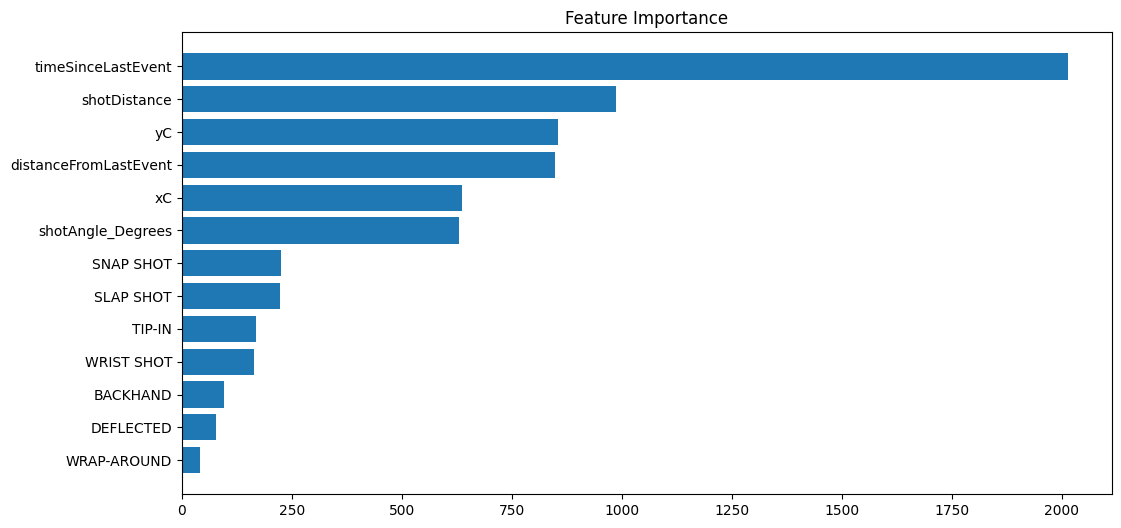

In [777]:
#Feature importance
from sklearn.inspection import permutation_importance
feature_importance = best_model.get_booster().get_score(importance_type='weight')

# Convert to array for plotting
sorted_idx = np.argsort(list(feature_importance.values()))
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), np.array(list(feature_importance.values()))[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(list(feature_importance.keys()))[sorted_idx])
plt.title('Feature Importance')
plt.show()

End of the Attempt at Grid Search

Now, set the parameters for the XGBoost Model

In [43]:
# params = {
#     'objective': 'binary:logistic',  # For probability output
#     'eval_metric': 'auc',  # Evaluation metric for binary classification
#     'max_depth': 4,  # Maximum depth of a tree
#     'eta': 0.1,  # Learning rate
#     'subsample': 0.8,  # Subsample ratio of the training instances
#     'colsample_bytree': 0.8  # Subsample ratio of columns when constructing each tree
# }



# params = {
#     'objective': 'binary:logistic',  # For probability output
#     'eval_metric': 'auc',  # Evaluation metric for binary classification
#     'max_depth': 6,  # Maximum depth of a tree
#     'eta': 0.01,  # Learning rate
#     'subsample': 0.8,  # Subsample ratio of the training instances
#     'colsample_bytree': 1,  # Subsample ratio of columns when constructing each tree
#     'gamma':4,
#     'min_child_weight':0
    
# }

Use CV to figure out the optimal number of boosting rounds to avoid overfitting

In [44]:
# cv_results = xgb.cv(
#     params,
#     dtrain,
#     num_boost_round=1000,  # A large number of rounds, allowing early stopping to decide
#     nfold=5,  # 5-fold cross-validation
#     metrics={'auc'},
#     early_stopping_rounds=10,  # Stop if no improvement for 10 rounds
#     seed=42
# )


In [45]:
# num_rounds=cv_results.shape[0]
# num_rounds

65

Now train the model

In [46]:
# bst = xgb.train(params, dtrain, num_rounds)

In [47]:
# y_XGBoost_pred=bst.predict(dtest)
# y_XGBoost_pred

array([0.07769614, 0.04399836, 0.07287128, ..., 0.08131695, 0.05441003,
       0.11158025], dtype=float32)

Evaluating the model

In [48]:
# # ROC AUC score
# roc_auc = roc_auc_score(y_test, y_XGBoost_pred)
# print(f'ROC AUC: {roc_auc}')

ROC AUC: 0.6147058480027617


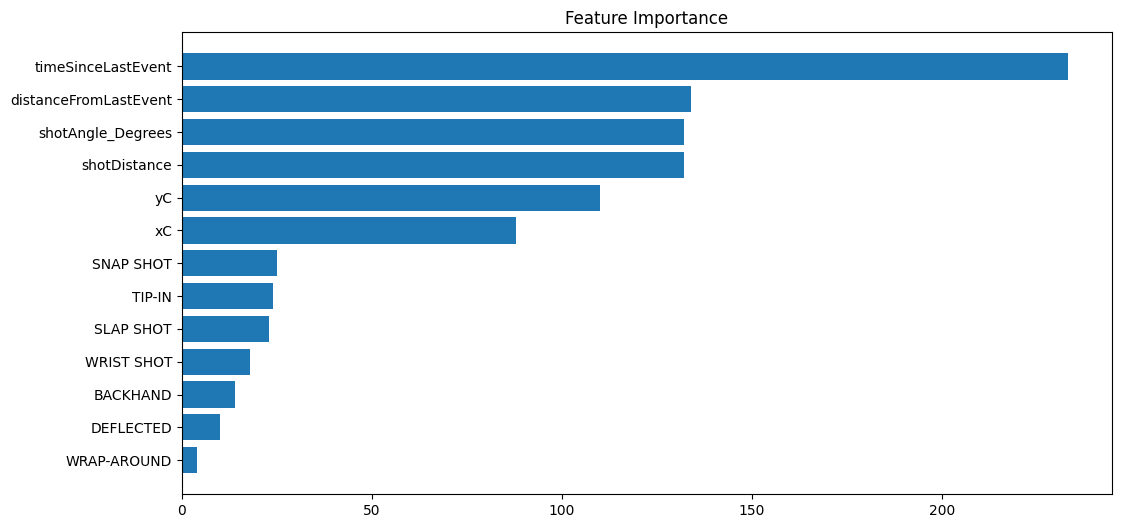

In [49]:
# #Feature importance
# from sklearn.inspection import permutation_importance
# feature_importance = bst.get_score(importance_type='weight')

# # Convert to array for plotting
# sorted_idx = np.argsort(list(feature_importance.values()))
# fig = plt.figure(figsize=(12, 6))
# plt.barh(range(len(sorted_idx)), np.array(list(feature_importance.values()))[sorted_idx], align='center')
# plt.yticks(range(len(sorted_idx)), np.array(list(feature_importance.keys()))[sorted_idx])
# plt.title('Feature Importance')
# plt.show()

Once Model is built, then since we are trying to find best forward lines, Group by player1, player2, player3. Sum their expected goals. Take top 15.

In [946]:
pred_varBoost= pbp[['timeSinceLastEvent','distanceFromLastEvent','Power Play','xC','yC','shotAngle_Degrees','shotDistance','BACKHAND', 'DEFLECTED', 'SLAP SHOT', 'SNAP SHOT', 'TIP-IN', 'WRAP-AROUND', 'WRIST SHOT']]

# Predict using the best_model
xG = best_model.predict_proba(pred_varBoost)[:, 1]

# Add the predictions to your DataFrame
pbp['xG'] = xG


# dtest=xgb.DMatrix(pred_varBoost)
# xG=bst.predict(dtest)
# pbp['xG']=xG

In [947]:
pbp.head()

,Ev_Zone,Ev_Team,Home_Team,Away_Team,Event,awayPlayer1,awayPlayer2,awayPlayer3,homePlayer1,homePlayer2,homePlayer3,Description,Strength,Seconds_Elapsed,timeSinceLastEvent,goal,distanceFromLastEvent,Power Play,xC,yC,shotAngle_Radians,shotAngle_Degrees,shotDistance,BACKHAND,DEFLECTED,SLAP SHOT,SNAP SHOT,TIP-IN,WRAP-AROUND,WRIST SHOT,Description,Type,xG
6,Off,T.B,T.B,NSH,SHOT,COLTON SISSONS,YAKOV TRENIN,COLE SMITH,BRAYDEN POINT,STEVEN STAMKOS,NIKITA KUCHEROV,"TBL ONGOAL - #43 RADDYSH, Wrist , Off. Zone, 3...",5x5,61.0,3.0,0,26.019224,0,44.0,-38.0,-0.701260,-40.199613,58.898217,0,0,0,0,0,0,1,"TBL ONGOAL - #43 RADDYSH, Wrist , Off. Zone, 3...",WRIST SHOT,0.098621
40,Off,T.B,T.B,NSH,SHOT,PHILIP TOMASINO,RYAN O'REILLY,LUKE EVANGELISTA,BRAYDEN POINT,STEVEN STAMKOS,NIKITA KUCHEROV,"TBL ONGOAL - #77 HEDMAN, Wrist , Off. Zone, 63...",5x5,564.0,4.0,0,56.142675,0,55.0,30.0,0.722979,41.444676,45.343136,0,0,0,0,0,0,1,"TBL ONGOAL - #77 HEDMAN, Wrist , Off. Zone, 63...",WRIST SHOT,0.064260
41,Off,T.B,T.B,NSH,GOAL,JUUSO PARSSINEN,RYAN O'REILLY,FILIP FORSBERG,BRAYDEN POINT,STEVEN STAMKOS,NIKITA KUCHEROV,"TBL #86 KUCHEROV(1), Slap , Off. Zone, 42 ft.A...",5x5,588.0,24.0,1,119.067208,0,64.0,34.0,0.936774,53.700398,42.201896,0,0,1,0,0,0,0,"TBL #86 KUCHEROV(1), Slap , Off. Zone, 42 ft.A...",SLAP SHOT,0.062019
44,Neu,T.B,T.B,NSH,MISS,JUUSO PARSSINEN,RYAN O'REILLY,FILIP FORSBERG,TYLER MOTTE,ANTHONY CIRELLI,BRANDON HAGEL,"TBL #64 MOTTE, Wrist, Wide Right, Neu. Zone, 8...",5x5,603.0,15.0,0,72.422372,0,69.0,22.0,0.832981,47.750518,29.732137,0,0,0,0,0,0,1,"TBL #64 MOTTE, Wrist, Wide Right, Neu. Zone, 8...",WRIST SHOT,0.053883
47,Off,T.B,T.B,NSH,SHOT,COLTON SISSONS,YAKOV TRENIN,COLE SMITH,LUKE GLENDENING,WALTTERI MERELA,TANNER JEANNOT,"TBL ONGOAL - #81 CERNAK, Snap , Off. Zone, 62 ...",5x5,615.0,9.0,0,50.009999,0,79.0,-27.0,-1.216091,-69.712204,28.792360,0,0,0,1,0,0,0,"TBL ONGOAL - #81 CERNAK, Snap , Off. Zone, 62 ...",SNAP SHOT,0.082742


Alright going to merge in nhl team logos so that I can display nicely in final dataframe once I group the forward lines. That way you can see which team the forward line belongs to. This requires me to load in the nhl logos csv, and also map the abbreviations so that I can merge onto the pbp dataframe.

In [948]:
nhl_logos=pd.read_csv("nhl_logos.csv")

Need to see the abbreviations from the pbp so I can create the mappings

In [949]:
pbp['Ev_Team'].unique()

array(['T.B', 'NSH', 'PIT', 'CHI', 'SEA', 'VGK', 'OTT', 'CAR', 'TOR',
       'MTL', 'BOS', 'WPG', 'CGY', 'COL', 'L.A', 'EDM', 'VAN', 'NYR',
       'BUF', 'CBJ', 'PHI', 'DET', 'N.J', 'DAL', 'STL', 'FLA', 'MIN',
       'S.J', 'ARI', 'WSH', 'NYI', 'ANA'], dtype=object)

In [950]:
nhl_logos.columns

Index(['refe_abrName', 'espn_team_name', 'espn_logo', 'primary', 'secondary',
       'tertiary', 'quaternary'],
      dtype='object')

In [951]:
nhl_logos['refe_abrName'].unique()

array(['CAR', 'CHI', 'CBJ', 'DAL', 'DET', 'FLA', 'NSH', 'TBL', 'BOS',
       'BUF', 'NJD', 'NYI', 'NYR', 'PHI', 'PIT', 'WSH', 'CGY', 'EDM',
       'MTL', 'OTT', 'TOR', 'VAN', 'WPG', 'ANA', 'ARI', 'COL', 'LAK',
       'MIN', 'SJS', 'STL', 'VEG', 'SEA'], dtype=object)

In [952]:
nhl_logos=nhl_logos[['refe_abrName','espn_logo']]

In [953]:
#Mapping dictionary
abbrev_map = {
    'T.B': 'TBL',   
    'NSH': 'NSH',
    'PIT': 'PIT',
    'CHI': 'CHI',  # Example: Golden Knights
    'SEA': 'SEA',
    'VGK': 'VEG',
    'OTT': 'OTT',
    'CAR': 'CAR',
    'TOR': 'TOR',
    'MTL': 'MTL',
    'BOS': 'BOS',
    'WPG': 'WPG',
    'CGY': 'CGY',
    'COL': 'COL',
    'L.A': 'LAK',
    'EDM': 'EDM',
    'VAN': 'VAN',
    'NYR': 'NYR',
    'BUF': 'BUF',
    'CBJ':'CBJ',
    'PHI':'PHI',
    'DET': 'DET',
    'N.J': 'NJD',
    'DAL': 'DAL',
    'STL': 'STL',
    'FLA': 'FLA',
    'MIN': 'MIN',
    'S.J': 'SJS',
    'ARI': 'ARI',
    'WSH':'WSH',
    'NYI':'NYI',
    'ANA':'ANA'

}

In [954]:
pbp['Ev_Team'] = pbp['Ev_Team'].map(abbrev_map).fillna(pbp['Ev_Team'])
pbp['Home_Team'] = pbp['Home_Team'].map(abbrev_map).fillna(pbp['Home_Team'])
pbp['Away_Team'] = pbp['Away_Team'].map(abbrev_map).fillna(pbp['Away_Team'])


In [955]:
#Merge for EV_Team logos
pbp_with_logos = pd.merge(pbp, nhl_logos, left_on='Ev_Team', right_on='refe_abrName', how='left')
pbp_with_logos.rename(columns={'espn_logo':'EV_espn_logo'}, inplace=True)
pbp_with_logos.drop(columns=['refe_abrName'], inplace=True)

# Merge for Home_Team logos
pbp_with_logos = pd.merge(pbp_with_logos, nhl_logos[['refe_abrName', 'espn_logo']], left_on='Home_Team', right_on='refe_abrName', how='left')
pbp_with_logos.rename(columns={'espn_logo': 'Home_Team_Logo'}, inplace=True)
pbp_with_logos.drop(columns=['refe_abrName'], inplace=True)  # Drop the merged abbreviation column if no longer needed

# Merge for Away_Team logos
pbp_with_logos = pd.merge(pbp_with_logos, nhl_logos[['refe_abrName', 'espn_logo']], left_on='Away_Team', right_on='refe_abrName', how='left')
pbp_with_logos.rename(columns={'espn_logo': 'Away_Team_Logo'}, inplace=True)
pbp_with_logos.drop(columns=['refe_abrName'], inplace=True)  # Drop the merged abbreviation column if no longer needed


In [956]:
pbp_with_logos.head()

,Ev_Zone,Ev_Team,Home_Team,Away_Team,Event,awayPlayer1,awayPlayer2,awayPlayer3,homePlayer1,homePlayer2,homePlayer3,Description,Strength,Seconds_Elapsed,timeSinceLastEvent,goal,distanceFromLastEvent,Power Play,xC,yC,shotAngle_Radians,shotAngle_Degrees,shotDistance,BACKHAND,DEFLECTED,SLAP SHOT,SNAP SHOT,TIP-IN,WRAP-AROUND,WRIST SHOT,Description,Type,xG,EV_espn_logo,Home_Team_Logo,Away_Team_Logo
0,Off,TBL,TBL,NSH,SHOT,COLTON SISSONS,YAKOV TRENIN,COLE SMITH,BRAYDEN POINT,STEVEN STAMKOS,NIKITA KUCHEROV,"TBL ONGOAL - #43 RADDYSH, Wrist , Off. Zone, 3...",5x5,61.0,3.0,0,26.019224,0,44.0,-38.0,-0.701260,-40.199613,58.898217,0,0,0,0,0,0,1,"TBL ONGOAL - #43 RADDYSH, Wrist , Off. Zone, 3...",WRIST SHOT,0.098621,https://a.espncdn.com/i/teamlogos/nhl/500/tb.png,https://a.espncdn.com/i/teamlogos/nhl/500/tb.png,https://a.espncdn.com/i/teamlogos/nhl/500/nsh.png
1,Off,TBL,TBL,NSH,SHOT,PHILIP TOMASINO,RYAN O'REILLY,LUKE EVANGELISTA,BRAYDEN POINT,STEVEN STAMKOS,NIKITA KUCHEROV,"TBL ONGOAL - #77 HEDMAN, Wrist , Off. Zone, 63...",5x5,564.0,4.0,0,56.142675,0,55.0,30.0,0.722979,41.444676,45.343136,0,0,0,0,0,0,1,"TBL ONGOAL - #77 HEDMAN, Wrist , Off. Zone, 63...",WRIST SHOT,0.064260,https://a.espncdn.com/i/teamlogos/nhl/500/tb.png,https://a.espncdn.com/i/teamlogos/nhl/500/tb.png,https://a.espncdn.com/i/teamlogos/nhl/500/nsh.png
2,Off,TBL,TBL,NSH,GOAL,JUUSO PARSSINEN,RYAN O'REILLY,FILIP FORSBERG,BRAYDEN POINT,STEVEN STAMKOS,NIKITA KUCHEROV,"TBL #86 KUCHEROV(1), Slap , Off. Zone, 42 ft.A...",5x5,588.0,24.0,1,119.067208,0,64.0,34.0,0.936774,53.700398,42.201896,0,0,1,0,0,0,0,"TBL #86 KUCHEROV(1), Slap , Off. Zone, 42 ft.A...",SLAP SHOT,0.062019,https://a.espncdn.com/i/teamlogos/nhl/500/tb.png,https://a.espncdn.com/i/teamlogos/nhl/500/tb.png,https://a.espncdn.com/i/teamlogos/nhl/500/nsh.png
3,Neu,TBL,TBL,NSH,MISS,JUUSO PARSSINEN,RYAN O'REILLY,FILIP FORSBERG,TYLER MOTTE,ANTHONY CIRELLI,BRANDON HAGEL,"TBL #64 MOTTE, Wrist, Wide Right, Neu. Zone, 8...",5x5,603.0,15.0,0,72.422372,0,69.0,22.0,0.832981,47.750518,29.732137,0,0,0,0,0,0,1,"TBL #64 MOTTE, Wrist, Wide Right, Neu. Zone, 8...",WRIST SHOT,0.053883,https://a.espncdn.com/i/teamlogos/nhl/500/tb.png,https://a.espncdn.com/i/teamlogos/nhl/500/tb.png,https://a.espncdn.com/i/teamlogos/nhl/500/nsh.png
4,Off,TBL,TBL,NSH,SHOT,COLTON SISSONS,YAKOV TRENIN,COLE SMITH,LUKE GLENDENING,WALTTERI MERELA,TANNER JEANNOT,"TBL ONGOAL - #81 CERNAK, Snap , Off. Zone, 62 ...",5x5,615.0,9.0,0,50.009999,0,79.0,-27.0,-1.216091,-69.712204,28.792360,0,0,0,1,0,0,0,"TBL ONGOAL - #81 CERNAK, Snap , Off. Zone, 62 ...",SNAP SHOT,0.082742,https://a.espncdn.com/i/teamlogos/nhl/500/tb.png,https://a.espncdn.com/i/teamlogos/nhl/500/tb.png,https://a.espncdn.com/i/teamlogos/nhl/500/nsh.png


Alright time to group by forward lines. 

In [957]:
# Step 1: Create separate columns for each player based on Ev_Team
pbp_with_logos['Player1'] = pbp_with_logos.apply(lambda row: row['awayPlayer1'] if row['Ev_Team'] == row['Away_Team'] else row['homePlayer1'], axis=1)
pbp_with_logos['Player2'] = pbp_with_logos.apply(lambda row: row['awayPlayer2'] if row['Ev_Team'] == row['Away_Team'] else row['homePlayer2'], axis=1)
pbp_with_logos['Player3'] = pbp_with_logos.apply(lambda row: row['awayPlayer3'] if row['Ev_Team'] == row['Away_Team'] else row['homePlayer3'], axis=1)
pbp_with_logos['Team'] = pbp_with_logos.apply(lambda row: row['Away_Team_Logo'] if row['Ev_Team'] == row['Away_Team'] else row['Home_Team_Logo'], axis=1)

# Step 2: Group by the three player columns and sum the xG
xg_ForwardLine = pbp_with_logos.groupby(['Player1', 'Player2', 'Player3','Team'])['xG'].sum().reset_index()


# View the result
xg_ForwardLine.head()

,Player1,Player2,Player3,Team,xG
0,ADAM ERNE,JAMES HAMBLIN,BRETT KULAK,https://a.espncdn.com/i/teamlogos/nhl/500/edm.png,0.054142
1,ADAM ERNE,JAMES HAMBLIN,EVANDER KANE,https://a.espncdn.com/i/teamlogos/nhl/500/edm.png,0.090595
2,ADAM ERNE,WARREN FOEGELE,JAMES HAMBLIN,https://a.espncdn.com/i/teamlogos/nhl/500/edm.png,0.053301
3,ADAM FANTILLI,ALEXANDRE TEXIER,DMITRI VORONKOV,https://a.espncdn.com/i/teamlogos/nhl/500/cbj.png,0.062565
4,ADAM FANTILLI,ALEXANDRE TEXIER,EMIL BEMSTROM,https://a.espncdn.com/i/teamlogos/nhl/500/cbj.png,1.598034


Moment of truth

In [958]:
xg_ForwardLine=xg_ForwardLine.sort_values(by='xG', ascending=False)
xg_ForwardLine=xg_ForwardLine.reset_index(drop=True)
# Step 2: Add a Rank column
xg_ForwardLine['Rank'] = xg_ForwardLine['xG'].rank(ascending=False, method='min').astype(int)

xg_ForwardLine.head(15)
xgFor_FL=xg_ForwardLine.head(15)

In [664]:
from PIL import Image
from io import BytesIO
from IPython.display import HTML

In [791]:
# Move the 'Team' column to be the first column
cols = ['Team'] + [col for col in xgFor_FL.columns if col != 'Team']
xgFor_FL = xgFor_FL[cols]

In [792]:
# Step 2: Reorder the columns to move 'Rank' to the desired position (e.g., column 0)
cols = ['Rank', 'Team', 'Player1', 'Player2', 'Player3', 'xG']  # Adjust this list based on your DataFrame's columns
xgFor_FL = xgFor_FL[cols]

In [793]:
# Custom function to render logos as images in the DataFrame
def render_logo(logo_url):
    return f'<img src="{logo_url}" width="40" height="40">'

# Applying the custom rendering and styling
styled_df = (
    xgFor_FL.style
    .set_caption("Top 15 Forward Lines by Expected Goals For (xG For)")  # Title of the DataFrame
    .set_table_styles([
        # Style for the title
        {'selector': 'caption', 'props': [('caption-side', 'top'), ('font-weight', 'bold'), ('font-size', '16px'), ('color', 'black'), ('background-color', 'white')]},
        # Mark the table with my name
        # Style for the column headers
        {'selector': 'th', 'props': [('font-weight', 'bold'), ('background-color', 'white'), ('color', 'black')]},
        {'selector': 'th.colxG::before', 'props': [('content', '"xG For"'), ('font-weight', 'bold')]},
        # Style for Player1, Player2, and Player3 columns
        {'selector': 'td.col0', 'props': [('background-color', 'white'), ('color', 'black')]},
        {'selector': 'td.col1', 'props': [('background-color', 'white'), ('color', 'black')]},
        {'selector': 'td.col2', 'props': [('background-color', 'white'), ('color', 'black')]},
        {'selector': 'td.col3', 'props': [('background-color', 'white'), ('color', 'black')]},
        {'selector': 'td.col4', 'props': [('background-color', 'white'), ('color', 'black')]}
    ])
    .background_gradient(subset=['xG'], cmap='Blues')  # Gradient color for xG column
    .format({'Team': render_logo}) # Apply the render_logo function to the Team_Logo column
)

# Render the DataFrame to HTML
html_output = styled_df.to_html()


# Replace the 'xG' header with 'xG For'
html_output = html_output.replace('>xG<', '>xG For<')

# Add a bottom caption directly in HTML
bottom_caption = '<p style="text-align: left; padding-left: 60px; font-size: 14px; font-weight: bold; color: black; background-color: white; margin: 0;">Created by Nick Sofianakos </p>'

# Combine the HTML table and bottom caption
full_html = html_output + bottom_caption

# Display the modified HTML
display(HTML(full_html))



# Display the styled DataFrame with images
# display(HTML(styled_df.to_html()))

,Rank,Team,Player1,Player2,Player3,xG For
0,1,,VINCENT TROCHECK,ARTEMI PANARIN,ALEXIS LAFRENIÈRE,42.190269
1,2,,GUSTAV NYQUIST,RYAN O'REILLY,FILIP FORSBERG,38.678131
2,3,,ANZE KOPITAR,ADRIAN KEMPE,QUINTON BYFIELD,36.434795
3,4,,BRAYDEN POINT,STEVEN STAMKOS,NIKITA KUCHEROV,34.906006
4,5,,JOE PAVELSKI,ROOPE HINTZ,JASON ROBERTSON,33.453220
5,6,,NICK SUZUKI,COLE CAUFIELD,JURAJ SLAFKOVSKY,32.089432
6,7,,NATHAN MACKINNON,VALERI NICHUSHKIN,MIKKO RANTANEN,31.070208
7,8,,NATHAN MACKINNON,MIKKO RANTANEN,JONATHAN DROUIN,29.977970
8,9,,VINCENT TROCHECK,MIKA ZIBANEJAD,ARTEMI PANARIN,29.226974
9,10,,PHILLIP DANAULT,TREVOR MOORE,KEVIN FIALA,28.864220


AWESOME. The above gives the best offensive lines in hockey by xG For. Looks great. Going to export to an html file, and then convert to png. 

In [405]:
# Save styled DataFrame to HTML
html_file = 'TopOffFL_table.html'
styled_df.to_html(html_file, render_links=True)

In [402]:
from html2image import Html2Image

In [406]:
output_file= 'TopOffFL_table.png'
h2i = Html2Image()
h2i.screenshot(html_file=html_file, save_as=output_file)

['c:\\Data Science Practice\\NHL-Forward-Lines-Ranking\\TopOffFL_table.png']

Now I want to calculate the best defensive lines in hockey by xG Against.

Since I don't have a minutes restriction, if I took the tail of the xG Against to find the combination of 3 players with the lowest xG, I would get combinations of players who barely played together. Thus, to get lines that actually played together, I am going to take lines that had >2 xG Against. This will ensure i get lines that played together enough. 

In [959]:
 #Step 1: Create separate columns for each opposing player based on Ev_Team
pbp_with_logos['Opp_Player1'] = pbp_with_logos.apply(lambda row: row['homePlayer1'] if row['Ev_Team'] == row['Away_Team'] else row['awayPlayer1'], axis=1)
pbp_with_logos['Opp_Player2'] = pbp_with_logos.apply(lambda row: row['homePlayer2'] if row['Ev_Team'] == row['Away_Team'] else row['awayPlayer2'], axis=1)
pbp_with_logos['Opp_Player3'] = pbp_with_logos.apply(lambda row: row['homePlayer3'] if row['Ev_Team'] == row['Away_Team'] else row['awayPlayer3'], axis=1)
pbp_with_logos['Team'] = pbp_with_logos.apply(lambda row: row['Home_Team_Logo'] if row['Ev_Team'] == row['Away_Team'] else row['Away_Team_Logo'], axis=1)

# Step 2: Group by the three opposing player columns and sum the xG
xg_Against = pbp_with_logos.groupby(['Opp_Player1', 'Opp_Player2', 'Opp_Player3','Team'])['xG'].sum().reset_index()

# Step 3: Sort the results by xG Against in descending order to find the highest xG Against lines
xg_Against = xg_Against.sort_values(by='xG', ascending=True)

In [870]:
#filter for xG >2
xg_Against=xg_Against[xg_Against['xG']>=2]

In [871]:
xg_Against['Rank'] = xg_Against['xG'].rank(ascending=True, method='min').astype(int)

In [872]:
xg_Against

,Opp_Player1,Opp_Player2,Opp_Player3,Team,xG,Rank
9727,RYAN NUGENT-HOPKINS,WARREN FOEGELE,EVANDER KANE,https://a.espncdn.com/i/teamlogos/nhl/500/edm.png,2.001019,1
5442,JOSH NORRIS,VLADIMIR TARASENKO,BRADY TKACHUK,https://a.espncdn.com/i/teamlogos/nhl/500/ott.png,2.001554,2
7063,MICHAEL MCLEOD,CURTIS LAZAR,NATHAN BASTIAN,https://a.espncdn.com/i/teamlogos/nhl/500/nj.png,2.004860,3
4198,JACK EICHEL,CHANDLER STEPHENSON,MARK STONE,https://a.espncdn.com/i/teamlogos/nhl/500/vgs.png,2.013506,4
8136,NICO STURM,LUKE KUNIN,WILLIAM EKLUND,https://a.espncdn.com/i/teamlogos/nhl/500/sj.png,2.016201,5
...,...,...,...,...,...,...
201,ADAM LOWRY,MASON APPLETON,NINO NIEDERREITER,https://a.espncdn.com/i/teamlogos/nhl/500/wpg.png,25.430140,605
11312,TYLER SEGUIN,MATT DUCHENE,MASON MARCHMENT,https://a.espncdn.com/i/teamlogos/nhl/500/dal.png,28.860943,606
7902,NICK SUZUKI,COLE CAUFIELD,JURAJ SLAFKOVSKY,https://a.espncdn.com/i/teamlogos/nhl/500/mtl.png,30.473534,607
4020,GUSTAV NYQUIST,RYAN O'REILLY,FILIP FORSBERG,https://a.espncdn.com/i/teamlogos/nhl/500/nsh.png,31.398317,608


In [798]:
xg_Against.head(15)

,Opp_Player1,Opp_Player2,Opp_Player3,Team,xG,Rank
9727,RYAN NUGENT-HOPKINS,WARREN FOEGELE,EVANDER KANE,https://a.espncdn.com/i/teamlogos/nhl/500/edm.png,2.001019,1
5442,JOSH NORRIS,VLADIMIR TARASENKO,BRADY TKACHUK,https://a.espncdn.com/i/teamlogos/nhl/500/ott.png,2.001554,2
7063,MICHAEL MCLEOD,CURTIS LAZAR,NATHAN BASTIAN,https://a.espncdn.com/i/teamlogos/nhl/500/nj.png,2.004860,3
4198,JACK EICHEL,CHANDLER STEPHENSON,MARK STONE,https://a.espncdn.com/i/teamlogos/nhl/500/vgs.png,2.013506,4
8136,NICO STURM,LUKE KUNIN,WILLIAM EKLUND,https://a.espncdn.com/i/teamlogos/nhl/500/sj.png,2.016201,5
7173,MICHAEL SGARBOSSA,NICOLAS AUBE-KUBEL,BECK MALENSTYN,https://a.espncdn.com/i/teamlogos/nhl/500/wsh.png,2.022230,6
11208,TY DELLANDREA,MATT DUCHENE,MASON MARCHMENT,https://a.espncdn.com/i/teamlogos/nhl/500/dal.png,2.023562,7
7641,NIC DOWD,TOM WILSON,BECK MALENSTYN,https://a.espncdn.com/i/teamlogos/nhl/500/wsh.png,2.026227,8
5325,JORDAN KYROU,KEVIN HAYES,BRANDON SAAD,https://a.espncdn.com/i/teamlogos/nhl/500/stl.png,2.026960,9
5467,JT MILLER,DAKOTA JOSHUA,CONOR GARLAND,https://a.espncdn.com/i/teamlogos/nhl/500/van.png,2.029261,10


Alright, now time to make it look good

In [799]:
xgAG_FL=xg_Against.head(15)

In [800]:
# Move the 'Team' column to be the first column
cols = ['Team'] + [col for col in xgAG_FL.columns if col != 'Team']
xgAG_FL = xgAG_FL[cols]

In [801]:
# Step 2: Reorder the columns to move 'Rank' to the desired position (e.g., column 0)
cols = ['Rank', 'Team', 'Opp_Player1', 'Opp_Player2', 'Opp_Player3', 'xG']  # Adjust this list based on your DataFrame's columns
xgAG_FL = xgAG_FL[cols]

In [802]:
xgAG_FL

,Rank,Team,Opp_Player1,Opp_Player2,Opp_Player3,xG
9727,1,https://a.espncdn.com/i/teamlogos/nhl/500/edm.png,RYAN NUGENT-HOPKINS,WARREN FOEGELE,EVANDER KANE,2.001019
5442,2,https://a.espncdn.com/i/teamlogos/nhl/500/ott.png,JOSH NORRIS,VLADIMIR TARASENKO,BRADY TKACHUK,2.001554
7063,3,https://a.espncdn.com/i/teamlogos/nhl/500/nj.png,MICHAEL MCLEOD,CURTIS LAZAR,NATHAN BASTIAN,2.004860
4198,4,https://a.espncdn.com/i/teamlogos/nhl/500/vgs.png,JACK EICHEL,CHANDLER STEPHENSON,MARK STONE,2.013506
8136,5,https://a.espncdn.com/i/teamlogos/nhl/500/sj.png,NICO STURM,LUKE KUNIN,WILLIAM EKLUND,2.016201
7173,6,https://a.espncdn.com/i/teamlogos/nhl/500/wsh.png,MICHAEL SGARBOSSA,NICOLAS AUBE-KUBEL,BECK MALENSTYN,2.022230
11208,7,https://a.espncdn.com/i/teamlogos/nhl/500/dal.png,TY DELLANDREA,MATT DUCHENE,MASON MARCHMENT,2.023562
7641,8,https://a.espncdn.com/i/teamlogos/nhl/500/wsh.png,NIC DOWD,TOM WILSON,BECK MALENSTYN,2.026227
5325,9,https://a.espncdn.com/i/teamlogos/nhl/500/stl.png,JORDAN KYROU,KEVIN HAYES,BRANDON SAAD,2.026960
5467,10,https://a.espncdn.com/i/teamlogos/nhl/500/van.png,JT MILLER,DAKOTA JOSHUA,CONOR GARLAND,2.029261


In [803]:
# Custom function to render logos as images in the DataFrame
def render_logo(logo_url):
    return f'<img src="{logo_url}" width="40" height="40">'

# Applying the custom rendering and styling
styled_df = (
    xgAG_FL.style
    .set_caption("Top 15 Forward Lines by Expected Goals Against (xG Against)")  # Title of the DataFrame
    .set_table_styles([
        # Style for the title
        {'selector': 'caption', 'props': [('caption-side', 'top'), ('font-weight', 'bold'), ('font-size', '16px'), ('color', 'black'), ('background-color', 'white')]},
        # Mark the table with my name
        # Style for the column headers
        {'selector': 'th', 'props': [('font-weight', 'bold'), ('background-color', 'white'), ('color', 'black')]},
        {'selector': 'th.colxG::before', 'props': [('content', '"xG Against"'), ('font-weight', 'bold')]},
        # Style for Player1, Player2, and Player3 columns
        {'selector': 'td.col0', 'props': [('background-color', 'white'), ('color', 'black')]},
        {'selector': 'td.col1', 'props': [('background-color', 'white'), ('color', 'black')]},
        {'selector': 'td.col2', 'props': [('background-color', 'white'), ('color', 'black')]},
        {'selector': 'td.col3', 'props': [('background-color', 'white'), ('color', 'black')]},
        {'selector': 'td.col4', 'props': [('background-color', 'white'), ('color', 'black')]}
    ])
    .background_gradient(subset=['xG'], cmap='Blues_r')  # Gradient color for xG column
    .format({'Team': render_logo}) # Apply the render_logo function to the Team_Logo column
)

# Render the DataFrame to HTML
html_output = styled_df.to_html()


# Replace the 'xG' header with 'xG For'
html_output = html_output.replace('>xG<', '>xG Against<')

# Add a bottom caption directly in HTML
bottom_caption = '<p style="text-align: left; padding-left: 60px; font-size: 14px; font-weight: bold; color: black; background-color: white; margin: 0;">Created by Nick Sofianakos </p>'

# Combine the HTML table and bottom caption
full_html = html_output + bottom_caption

# Display the modified HTML
display(HTML(full_html))


,Rank,Team,Opp_Player1,Opp_Player2,Opp_Player3,xG Against
9727,1,,RYAN NUGENT-HOPKINS,WARREN FOEGELE,EVANDER KANE,2.001019
5442,2,,JOSH NORRIS,VLADIMIR TARASENKO,BRADY TKACHUK,2.001554
7063,3,,MICHAEL MCLEOD,CURTIS LAZAR,NATHAN BASTIAN,2.004860
4198,4,,JACK EICHEL,CHANDLER STEPHENSON,MARK STONE,2.013506
8136,5,,NICO STURM,LUKE KUNIN,WILLIAM EKLUND,2.016201
7173,6,,MICHAEL SGARBOSSA,NICOLAS AUBE-KUBEL,BECK MALENSTYN,2.022230
11208,7,,TY DELLANDREA,MATT DUCHENE,MASON MARCHMENT,2.023562
7641,8,,NIC DOWD,TOM WILSON,BECK MALENSTYN,2.026227
5325,9,,JORDAN KYROU,KEVIN HAYES,BRANDON SAAD,2.026960
5467,10,,JT MILLER,DAKOTA JOSHUA,CONOR GARLAND,2.029261


Since I have no minutes filter, a lot of forward groupings that don't have a lot of minutes are in the xG Against top lines. But not significant since they barely played together. THus, I am going to try and utilize the nhl shifts dataframe to calculate the TOI for all forward combinations, and then merge it into the xG For and xG Against data frames so the time on ice for each line shows. That way, I can filter by certain TOI thresholds to get rid of line combinations in the leaderboard that barely played together. 

In [55]:
# shifts.head()

,Unnamed: 0,Game_Id,Period,Team,Player,Player_Id,Start,End,Duration,Date
0,0,20001,1,NSH,RYAN MCDONAGH,8474151.0,0.0,30.0,30.0,2023-10-10
1,1,20001,1,NSH,RYAN O'REILLY,8475158.0,0.0,35.0,35.0,2023-10-10
2,2,20001,1,T.B,VICTOR HEDMAN,8475167.0,0.0,41.0,41.0,2023-10-10
3,3,20001,1,NSH,FILIP FORSBERG,8476887.0,0.0,32.0,32.0,2023-10-10
4,4,20001,1,T.B,TYLER MOTTE,8477353.0,0.0,32.0,32.0,2023-10-10


In [56]:
# Create combinations of three players on the ice together
# from itertools import combinations

# shift_combinations = []

In [61]:
# for game_id, period in shifts.groupby(['Game_Id', 'Period']):
#     players_on_ice = {}

#     for _, row in period.iterrows():
#         for time in range(int(row['Start']), int(row['End']) + 1):
#             players_on_ice.setdefault(time, []).append(row['Player'])

#     for time, players in players_on_ice.items():
#         if len(players) >= 3:
#             for combo in combinations(sorted(players), 3):
#                 shift_combinations.append((game_id, row['Period'], combo[0], combo[1], combo[2], time))

MemoryError: 

Didnt work because I ran out of memory. Instead of manually creating each group of 3's Time on Ice (TOI), I'm going to take a shortcut and use MoneyPuck's Line data. This is done towards the bottom.

Now, I have to get the GF%

In [804]:
xg_combined = pd.merge(
    xg_ForwardLine, 
    xg_Against, 
    left_on=['Player1', 'Player2', 'Player3','Team'], 
    right_on=['Opp_Player1', 'Opp_Player2', 'Opp_Player3','Team'],
    suffixes=('_For', '_Against')
)

# Step 2: Calculate the xG%
xg_combined['xG%'] = xg_combined['xG_For'] / (xg_combined['xG_For'] + xg_combined['xG_Against'])

xg_combined = xg_combined.sort_values(by='xG%', ascending=False)

# Step 3: Display the result
xg_combined[['Player1', 'Player2', 'Player3', 'xG_For', 'xG_Against', 'xG%','Team']].head()

,Player1,Player2,Player3,xG_For,xG_Against,xG%,Team
8,VINCENT TROCHECK,MIKA ZIBANEJAD,ARTEMI PANARIN,29.226974,3.762718,0.885943,https://a.espncdn.com/i/teamlogos/nhl/500/nyr.png
25,JOEL ERIKSSON EK,MATS ZUCCARELLO,MATT BOLDY,19.840506,2.855797,0.874173,https://a.espncdn.com/i/teamlogos/nhl/500/min.png
14,LEON DRAISAITL,RYAN NUGENT-HOPKINS,CONNOR MCDAVID,26.472658,4.152081,0.864421,https://a.espncdn.com/i/teamlogos/nhl/500/edm.png
37,AUSTON MATTHEWS,JOHN TAVARES,MITCHELL MARNER,15.694560,2.939484,0.842252,https://a.espncdn.com/i/teamlogos/nhl/500/tor.png
34,JOE PAVELSKI,ROOPE HINTZ,JAMIE BENN,16.507666,3.964504,0.806347,https://a.espncdn.com/i/teamlogos/nhl/500/dal.png


Now to create final dataframe of xG%

In [805]:
xg_combined=xg_combined[(xg_combined['xG_For']>=3) & (xg_combined['xG_Against']>=2)]

In [806]:
# Move the 'Team' column to be the first column
cols = ['Team'] + [col for col in xg_combined.columns if col != 'Team']
xg_combined = xg_combined[cols]

In [807]:
xg_combined['Rank'] = xg_combined['xG%'].rank(ascending=False, method='min').astype(int)

In [808]:
Best_FL=xg_combined[['Rank','Team','Player1', 'Player2', 'Player3','xG%']].head(15)

In [809]:
Best_FL

,Rank,Team,Player1,Player2,Player3,xG%
8,1,https://a.espncdn.com/i/teamlogos/nhl/500/nyr.png,VINCENT TROCHECK,MIKA ZIBANEJAD,ARTEMI PANARIN,0.885943
25,2,https://a.espncdn.com/i/teamlogos/nhl/500/min.png,JOEL ERIKSSON EK,MATS ZUCCARELLO,MATT BOLDY,0.874173
14,3,https://a.espncdn.com/i/teamlogos/nhl/500/edm.png,LEON DRAISAITL,RYAN NUGENT-HOPKINS,CONNOR MCDAVID,0.864421
37,4,https://a.espncdn.com/i/teamlogos/nhl/500/tor.png,AUSTON MATTHEWS,JOHN TAVARES,MITCHELL MARNER,0.842252
34,5,https://a.espncdn.com/i/teamlogos/nhl/500/dal.png,JOE PAVELSKI,ROOPE HINTZ,JAMIE BENN,0.806347
24,6,https://a.espncdn.com/i/teamlogos/nhl/500/nyi.png,MATHEW BARZAL,BO HORVAT,KYLE PALMIERI,0.786677
59,7,https://a.espncdn.com/i/teamlogos/nhl/500/car.png,SEBASTIAN AHO,SETH JARVIS,ANDREI SVECHNIKOV,0.780595
68,8,https://a.espncdn.com/i/teamlogos/nhl/500/pit.png,EVGENI MALKIN,SIDNEY CROSBY,BRYAN RUST,0.780179
137,9,https://a.espncdn.com/i/teamlogos/nhl/500/vgs.png,JACK EICHEL,CHANDLER STEPHENSON,MARK STONE,0.776492
90,10,https://a.espncdn.com/i/teamlogos/nhl/500/mtl.png,NICK SUZUKI,ALEX NEWHOOK,COLE CAUFIELD,0.771945


In [810]:
# Custom function to render logos as images in the DataFrame
def render_logo(logo_url):
    return f'<img src="{logo_url}" width="40" height="40">'

# Applying the custom rendering and styling
styled_df = (
    Best_FL.style
    .set_caption("Top 15 Forward Lines by Expected Goals Percentage (xG%)")  # Title of the DataFrame
    .set_table_styles([
        # Style for the title
        {'selector': 'caption', 'props': [('caption-side', 'top'), ('font-weight', 'bold'), ('font-size', '16px'), ('color', 'black'), ('background-color', 'white')]},
        # Mark the table with my name
        # Style for the column headers
        {'selector': 'th', 'props': [('font-weight', 'bold'), ('background-color', 'white'), ('color', 'black')]},
        #{'selector': 'th.colxG::before', 'props': [('content', '"xG Against"'), ('font-weight', 'bold')]},
        # Style for Player1, Player2, and Player3 columns
        {'selector': 'td.col0', 'props': [('background-color', 'white'), ('color', 'black')]},
        {'selector': 'td.col1', 'props': [('background-color', 'white'), ('color', 'black')]},
        {'selector': 'td.col2', 'props': [('background-color', 'white'), ('color', 'black')]},
        {'selector': 'td.col3', 'props': [('background-color', 'white'), ('color', 'black')]},
        {'selector': 'td.col4', 'props': [('background-color', 'white'), ('color', 'black')]}
    ])
    .background_gradient(subset=['xG%'], cmap='Blues')  # Gradient color for xG column
    .format({'Team': render_logo}) # Apply the render_logo function to the Team_Logo column
)

# Render the DataFrame to HTML
html_output = styled_df.to_html()


# Replace the 'xG' header with 'xG For'
html_output = html_output.replace('>xG<', '>xG Against<')

# Add a bottom caption directly in HTML
bottom_caption = '<p style="text-align: left; padding-left: 60px; font-size: 14px; font-weight: bold; color: black; background-color: white; margin: 0;">Created by Nick Sofianakos </p>'

# Combine the HTML table and bottom caption
full_html = html_output + bottom_caption

# Display the modified HTML
display(HTML(full_html))

,Rank,Team,Player1,Player2,Player3,xG%
8,1,,VINCENT TROCHECK,MIKA ZIBANEJAD,ARTEMI PANARIN,0.885943
25,2,,JOEL ERIKSSON EK,MATS ZUCCARELLO,MATT BOLDY,0.874173
14,3,,LEON DRAISAITL,RYAN NUGENT-HOPKINS,CONNOR MCDAVID,0.864421
37,4,,AUSTON MATTHEWS,JOHN TAVARES,MITCHELL MARNER,0.842252
34,5,,JOE PAVELSKI,ROOPE HINTZ,JAMIE BENN,0.806347
24,6,,MATHEW BARZAL,BO HORVAT,KYLE PALMIERI,0.786677
59,7,,SEBASTIAN AHO,SETH JARVIS,ANDREI SVECHNIKOV,0.780595
68,8,,EVGENI MALKIN,SIDNEY CROSBY,BRYAN RUST,0.780179
137,9,,JACK EICHEL,CHANDLER STEPHENSON,MARK STONE,0.776492
90,10,,NICK SUZUKI,ALEX NEWHOOK,COLE CAUFIELD,0.771945


Alright, problem with the above rankings is that minutes played or TOI is not taken into account. Some of these combinations have barely played together and so we need to get the true best lines in hockey by implementing a minimum TOI requirement. Im going to do this by loading in data from moneypuck. 

In [552]:
# MP=pd.read_csv("lines.csv")

In [553]:
# MP.head()

,lineId,season,name,team,position,situation,games_played,icetime,iceTimeRank,xGoalsPercentage,corsiPercentage,fenwickPercentage,xOnGoalFor,xGoalsFor,xReboundsFor,xFreezeFor,xPlayStoppedFor,xPlayContinuedInZoneFor,xPlayContinuedOutsideZoneFor,flurryAdjustedxGoalsFor,scoreVenueAdjustedxGoalsFor,flurryScoreVenueAdjustedxGoalsFor,shotsOnGoalFor,missedShotsFor,blockedShotAttemptsFor,shotAttemptsFor,goalsFor,reboundsFor,reboundGoalsFor,freezeFor,playStoppedFor,playContinuedInZoneFor,playContinuedOutsideZoneFor,savedShotsOnGoalFor,savedUnblockedShotAttemptsFor,penaltiesFor,penalityMinutesFor,faceOffsWonFor,hitsFor,takeawaysFor,giveawaysFor,lowDangerShotsFor,mediumDangerShotsFor,highDangerShotsFor,lowDangerxGoalsFor,mediumDangerxGoalsFor,highDangerxGoalsFor,lowDangerGoalsFor,mediumDangerGoalsFor,highDangerGoalsFor,scoreAdjustedShotsAttemptsFor,unblockedShotAttemptsFor,scoreAdjustedUnblockedShotAttemptsFor,dZoneGiveawaysFor,xGoalsFromxReboundsOfShotsFor,xGoalsFromActualReboundsOfShotsFor,reboundxGoalsFor,totalShotCreditFor,scoreAdjustedTotalShotCreditFor,scoreFlurryAdjustedTotalShotCreditFor,xOnGoalAgainst,xGoalsAgainst,xReboundsAgainst,xFreezeAgainst,xPlayStoppedAgainst,xPlayContinuedInZoneAgainst,xPlayContinuedOutsideZoneAgainst,flurryAdjustedxGoalsAgainst,scoreVenueAdjustedxGoalsAgainst,flurryScoreVenueAdjustedxGoalsAgainst,shotsOnGoalAgainst,missedShotsAgainst,blockedShotAttemptsAgainst,shotAttemptsAgainst,goalsAgainst,reboundsAgainst,reboundGoalsAgainst,freezeAgainst,playStoppedAgainst,playContinuedInZoneAgainst,playContinuedOutsideZoneAgainst,savedShotsOnGoalAgainst,savedUnblockedShotAttemptsAgainst,penaltiesAgainst,penalityMinutesAgainst,faceOffsWonAgainst,hitsAgainst,takeawaysAgainst,giveawaysAgainst,lowDangerShotsAgainst,mediumDangerShotsAgainst,highDangerShotsAgainst,lowDangerxGoalsAgainst,mediumDangerxGoalsAgainst,highDangerxGoalsAgainst,lowDangerGoalsAgainst,mediumDangerGoalsAgainst,highDangerGoalsAgainst,scoreAdjustedShotsAttemptsAgainst,unblockedShotAttemptsAgainst,scoreAdjustedUnblockedShotAttemptsAgainst,dZoneGiveawaysAgainst,xGoalsFromxReboundsOfShotsAgainst,xGoalsFromActualReboundsOfShotsAgainst,reboundxGoalsAgainst,totalShotCreditAgainst,scoreAdjustedTotalShotCreditAgainst,scoreFlurryAdjustedTotalShotCreditAgainst
0,847793384801858482113,2023,Luostarinen-Lundell-Reinhart,FLA,line,5on5,24,7819.0,172.0,0.60,0.58,0.58,72.48,5.84,4.77,19.32,2.80,39.84,28.43,5.61,5.76,5.55,60.0,41.0,48.0,149.0,4.0,9.0,1.0,16.0,0.0,39.0,33.0,56.0,97.0,11.0,22.0,80.0,48.0,18.0,24.0,79.0,17.0,5.0,2.34,2.24,1.25,0.0,4.0,0.0,146.89,101.0,100.28,14.0,1.00,1.60,1.60,5.24,5.21,5.07,53.41,3.93,3.35,13.63,1.81,29.21,22.08,3.83,4.00,3.90,49.0,25.0,33.0,107.0,4.0,2.0,1.0,14.0,0.0,22.0,32.0,45.0,70.0,10.0,20.0,67.0,81.0,10.0,21.0,60.0,12.0,2.0,1.65,1.54,0.73,2.0,1.0,1.0,107.37,74.0,74.65,13.0,0.70,0.63,0.63,3.99,4.05,4.01
1,84758258476902,2023,Lindell-Hakanp,DAL,pairing,5on5,61,36226.0,179.0,0.53,0.47,0.49,296.53,25.35,19.18,71.98,9.96,161.85,120.66,24.46,25.45,24.57,285.0,124.0,164.0,573.0,31.0,28.0,5.0,55.0,3.0,141.0,151.0,254.0,378.0,32.0,66.0,314.0,255.0,58.0,90.0,305.0,77.0,27.0,8.70,9.16,7.50,13.0,10.0,8.0,582.92,409.0,413.71,43.0,3.98,5.89,5.73,23.59,23.83,23.48,309.71,22.63,18.71,82.17,10.34,168.31,126.86,21.88,22.70,21.93,297.0,132.0,207.0,636.0,32.0,23.0,4.0,89.0,2.0,149.0,134.0,265.0,397.0,33.0,64.0,248.0,312.0,47.0,70.0,343.0,67.0,19.0,9.42,8.10,5.12,15.0,12.0,5.0,629.97,429.0,426.70,32.0,3.88,3.94,3.94,22.58,22.65,22.22
2,847579884793168480821,2023,Kunin-Granlund-Zadina,SJS,line,5on5,7,1073.0,65.0,0.25,0.32,0.31,7.08,0.40,0.48,1.61,0.26,3.91,3.35,0.39,0.40,0.39,6.0,4.0,4.0,14.0,0.0,0.0,0.0,0.0,0.0,3.0,7.0,6.0,10.0,2.0,7.0,5.0,8.0,0.0,1.0,9.0,1.0,0.0,0.32,0.08,0.00,0.0,0.0,0.0,13.24,10.0,9.63,0.0,0.10,0.00,0.00,0.50,0.50,0.49,16.51,1.18,1.03,3.72,0.49,8.76,6.83,1.15,1.20,1.18,18.0,4.0,8.0,30.0,2.0,1.0,1.0,2.0,0.0,10.0,7.0,16.0,20.0,4.0,11.0,7.0,7.0,4.0,3.0,17.0,5.0,0.0,0.47,0.71,0.00,1.0,1.0,0.0,31.61,22.0,22.77,3.0,0.21,0.14,0.14,1.25,1.2

In [554]:
# MP= MP[['lineId','name','team','position','icetime','iceTimeRank','games_played','situation']]

In [555]:
# MP['situation'].value_counts()

situation
5on5    2948
Name: count, dtype: int64

In [559]:
# MP=MP[MP['position']=='line']

In [560]:
# MP.head()

,lineId,name,team,position,icetime,iceTimeRank,games_played,situation
0,847793384801858482113,Luostarinen-Lundell-Reinhart,FLA,line,7819.0,172.0,24,5on5
2,847579884793168480821,Kunin-Granlund-Zadina,SJS,line,1073.0,65.0,7,5on5
4,847793984784838479318,Marner-Matthews-Nylander,TOR,line,2425.0,346.0,31,5on5
5,847595884816568482148,Protas-Lapierre-Sgarbossa,WSH,line,821.0,30.0,4,5on5
8,847821184784218479291,Greer-Rooney-Hunt,CGY,line,1808.0,23.0,5,5on5


In [557]:
# MP['position'].value_counts()

position
line    1976
Name: count, dtype: int64

In [558]:
# MP['name'].unique()

array(['Luostarinen-Lundell-Reinhart', 'Kunin-Granlund-Zadina',
       'Marner-Matthews-Nylander', ..., 'Pezzetta-Evans-Harvey-Pinard',
       'Heinen-Poitras-Boqvist', 'Perron-Veleno-Rasmussen'], dtype=object)

Alright will not be able to split by - as some players have a - in their name. Thus, find another approach. Going to try and split into 4 columns, should just have an extra column that will contain bad splits for players that have the -. Then manually in excel just go through and put the - names back together, and delete that extra column

In [561]:
# MP[['Player1', 'Player2', 'Player3', 'Temp']] = MP['name'].str.split('-', expand=True)

In [562]:
# MP.to_csv("Temp.csv")

Handled edge case names maually in excel. Should be all set now to load the data back in

In [811]:
monpuck= pd.read_csv("Temp.csv")

In [812]:
monpuck.head()

,Unnamed: 0,lineId,name,team,position,icetime,iceTimeRank,games_played,situation,Player1,Player2,Player3
0,0,847793384801858482113,Luostarinen-Lundell-Reinhart,FLA,line,7819,172,24,5on5,Luostarinen,Lundell,Reinhart
1,2,847579884793168480821,Kunin-Granlund-Zadina,SJS,line,1073,65,7,5on5,Kunin,Granlund,Zadina
2,4,847793984784838479318,Marner-Matthews-Nylander,TOR,line,2425,346,31,5on5,Marner,Matthews,Nylander
3,5,847595884816568482148,Protas-Lapierre-Sgarbossa,WSH,line,821,30,4,5on5,Protas,Lapierre,Sgarbossa
4,8,847821184784218479291,Greer-Rooney-Hunt,CGY,line,1808,23,5,5on5,Greer,Rooney,Hunt


monpuck now has the same player1, player2, player3 format as the pbp data. just have to convert to uppercase

In [813]:
monpuck[['Player1', 'Player2', 'Player3']] = monpuck[['Player1', 'Player2', 'Player3']].apply(lambda x: x.str.upper())

In [814]:
monpuck.head()

,Unnamed: 0,lineId,name,team,position,icetime,iceTimeRank,games_played,situation,Player1,Player2,Player3
0,0,847793384801858482113,Luostarinen-Lundell-Reinhart,FLA,line,7819,172,24,5on5,LUOSTARINEN,LUNDELL,REINHART
1,2,847579884793168480821,Kunin-Granlund-Zadina,SJS,line,1073,65,7,5on5,KUNIN,GRANLUND,ZADINA
2,4,847793984784838479318,Marner-Matthews-Nylander,TOR,line,2425,346,31,5on5,MARNER,MATTHEWS,NYLANDER
3,5,847595884816568482148,Protas-Lapierre-Sgarbossa,WSH,line,821,30,4,5on5,PROTAS,LAPIERRE,SGARBOSSA
4,8,847821184784218479291,Greer-Rooney-Hunt,CGY,line,1808,23,5,5on5,GREER,ROONEY,HUNT


Alright now going to attempt a merge with the the xG For dataframe. We will see. 
Step 1 is to ensure both have same consistent naming in the Player1, Player2, Player3 columns

In [815]:
monpuck[['Player1', 'Player2', 'Player3']] = monpuck[['Player1', 'Player2', 'Player3']].apply(lambda x: x.str.upper().str.strip())
xg_ForwardLine[['Player1', 'Player2', 'Player3']] = xg_ForwardLine[['Player1', 'Player2', 'Player3']].apply(lambda x: x.str.upper().str.strip())

In [816]:
xg_ForwardLine.head()

,Player1,Player2,Player3,Team,xG,Rank
0,VINCENT TROCHECK,ARTEMI PANARIN,ALEXIS LAFRENIÈRE,https://a.espncdn.com/i/teamlogos/nhl/500/nyr.png,42.190269,1
1,GUSTAV NYQUIST,RYAN O'REILLY,FILIP FORSBERG,https://a.espncdn.com/i/teamlogos/nhl/500/nsh.png,38.678131,2
2,ANZE KOPITAR,ADRIAN KEMPE,QUINTON BYFIELD,https://a.espncdn.com/i/teamlogos/nhl/500/la.png,36.434795,3
3,BRAYDEN POINT,STEVEN STAMKOS,NIKITA KUCHEROV,https://a.espncdn.com/i/teamlogos/nhl/500/tb.png,34.906006,4
4,JOE PAVELSKI,ROOPE HINTZ,JASON ROBERTSON,https://a.espncdn.com/i/teamlogos/nhl/500/dal.png,33.453220,5


Have to make sure xg_ForwardLine is just last names of players before we sort. Since the monpuck is just lastnames

In [817]:
# Function to extract the last name
def get_last_name(full_name):
    return full_name.split()[-1] if pd.notna(full_name) else ''

In [818]:
xg_ForwardLine[['Player1', 'Player2', 'Player3']] = xg_ForwardLine[['Player1', 'Player2', 'Player3']].applymap(get_last_name)

DataFrame.applymap has been deprecated. Use DataFrame.map instead.


In [819]:
xg_ForwardLine.head()

,Player1,Player2,Player3,Team,xG,Rank
0,TROCHECK,PANARIN,LAFRENIÈRE,https://a.espncdn.com/i/teamlogos/nhl/500/nyr.png,42.190269,1
1,NYQUIST,O'REILLY,FORSBERG,https://a.espncdn.com/i/teamlogos/nhl/500/nsh.png,38.678131,2
2,KOPITAR,KEMPE,BYFIELD,https://a.espncdn.com/i/teamlogos/nhl/500/la.png,36.434795,3
3,POINT,STAMKOS,KUCHEROV,https://a.espncdn.com/i/teamlogos/nhl/500/tb.png,34.906006,4
4,PAVELSKI,HINTZ,ROBERTSON,https://a.espncdn.com/i/teamlogos/nhl/500/dal.png,33.453220,5


In [820]:
xg_ForwardLine = xg_ForwardLine.replace('LAFRENIÈRE', 'LAFRENIERE')

In [821]:
xg_ForwardLine.head()

,Player1,Player2,Player3,Team,xG,Rank
0,TROCHECK,PANARIN,LAFRENIERE,https://a.espncdn.com/i/teamlogos/nhl/500/nyr.png,42.190269,1
1,NYQUIST,O'REILLY,FORSBERG,https://a.espncdn.com/i/teamlogos/nhl/500/nsh.png,38.678131,2
2,KOPITAR,KEMPE,BYFIELD,https://a.espncdn.com/i/teamlogos/nhl/500/la.png,36.434795,3
3,POINT,STAMKOS,KUCHEROV,https://a.espncdn.com/i/teamlogos/nhl/500/tb.png,34.906006,4
4,PAVELSKI,HINTZ,ROBERTSON,https://a.espncdn.com/i/teamlogos/nhl/500/dal.png,33.453220,5


Now sort each line alphabetically so that we can successfully compare and merge the two dataframes.

In [822]:
monpuck[['Player1', 'Player2', 'Player3']] = monpuck[['Player1', 'Player2', 'Player3']].apply(lambda row: pd.Series(sorted(row)), axis=1)
xg_ForwardLine[['Player1', 'Player2', 'Player3']] = xg_ForwardLine[['Player1', 'Player2', 'Player3']].apply(lambda row: pd.Series(sorted(row)), axis=1)

In [823]:
monpuck.head()

,Unnamed: 0,lineId,name,team,position,icetime,iceTimeRank,games_played,situation,Player1,Player2,Player3
0,0,847793384801858482113,Luostarinen-Lundell-Reinhart,FLA,line,7819,172,24,5on5,LUNDELL,LUOSTARINEN,REINHART
1,2,847579884793168480821,Kunin-Granlund-Zadina,SJS,line,1073,65,7,5on5,GRANLUND,KUNIN,ZADINA
2,4,847793984784838479318,Marner-Matthews-Nylander,TOR,line,2425,346,31,5on5,MARNER,MATTHEWS,NYLANDER
3,5,847595884816568482148,Protas-Lapierre-Sgarbossa,WSH,line,821,30,4,5on5,LAPIERRE,PROTAS,SGARBOSSA
4,8,847821184784218479291,Greer-Rooney-Hunt,CGY,line,1808,23,5,5on5,GREER,HUNT,ROONEY


In [824]:
xg_ForwardLine.head()

,Player1,Player2,Player3,Team,xG,Rank
0,LAFRENIERE,PANARIN,TROCHECK,https://a.espncdn.com/i/teamlogos/nhl/500/nyr.png,42.190269,1
1,FORSBERG,NYQUIST,O'REILLY,https://a.espncdn.com/i/teamlogos/nhl/500/nsh.png,38.678131,2
2,BYFIELD,KEMPE,KOPITAR,https://a.espncdn.com/i/teamlogos/nhl/500/la.png,36.434795,3
3,KUCHEROV,POINT,STAMKOS,https://a.espncdn.com/i/teamlogos/nhl/500/tb.png,34.906006,4
4,HINTZ,PAVELSKI,ROBERTSON,https://a.espncdn.com/i/teamlogos/nhl/500/dal.png,33.453220,5


FIgured it out have to get rid of the first names in the xg_Forwardline dataframe because monpuck only contains last name

Now, its time to merge the two dataframes. Lets see what we get...

In [825]:
# Merge the DataFrames based on the player columns
merged_df_XG_For = pd.merge(monpuck, xg_ForwardLine, on=['Player1', 'Player2', 'Player3'], how='left')


In [826]:
merged_df_XG_For.head()

,Unnamed: 0,lineId,name,team,position,icetime,iceTimeRank,games_played,situation,Player1,Player2,Player3,Team,xG,Rank
0,0,847793384801858482113,Luostarinen-Lundell-Reinhart,FLA,line,7819,172,24,5on5,LUNDELL,LUOSTARINEN,REINHART,https://a.espncdn.com/i/teamlogos/nhl/500/fla.png,6.498608,160.0
1,2,847579884793168480821,Kunin-Granlund-Zadina,SJS,line,1073,65,7,5on5,GRANLUND,KUNIN,ZADINA,https://a.espncdn.com/i/teamlogos/nhl/500/sj.png,0.689780,1662.0
2,4,847793984784838479318,Marner-Matthews-Nylander,TOR,line,2425,346,31,5on5,MARNER,MATTHEWS,NYLANDER,https://a.espncdn.com/i/teamlogos/nhl/500/tor.png,4.962447,214.0
3,5,847595884816568482148,Protas-Lapierre-Sgarbossa,WSH,line,821,30,4,5on5,LAPIERRE,PROTAS,SGARBOSSA,https://a.espncdn.com/i/teamlogos/nhl/500/wsh.png,0.326855,2970.0
4,8,847821184784218479291,Greer-Rooney-Hunt,CGY,line,1808,23,5,5on5,GREER,HUNT,ROONEY,https://a.espncdn.com/i/teamlogos/nhl/500/cgy.png,1.214996,1024.0


Should be all good

In [599]:
# player1 = 'MARNER'
# player2 = 'MATTHEWS'
# player3 = 'NYLANDER'

# # Find the row(s) where Player1, Player2, and Player3 match the given names
# result = xg_ForwardLine[
#     (xg_ForwardLine['Player1'] == player1) &
#     (xg_ForwardLine['Player2'] == player2) &
#     (xg_ForwardLine['Player3'] == player3)
# ]

# print(result)

Empty DataFrame
Columns: [Player1, Player2, Player3, Team, xG, Rank]
Index: []


In [827]:
merged_df_XG_For=merged_df_XG_For.sort_values(by='xG',ascending=False)

In [828]:
merged_df_XG_For.head(18)

,Unnamed: 0,lineId,name,team,position,icetime,iceTimeRank,games_played,situation,Player1,Player2,Player3,Team,xG,Rank
830,1202,847638984785508482109,Lafreniere-Trocheck-Panarin,NYR,line,51785,97,74,5on5,LAFRENIERE,PANARIN,TROCHECK,https://a.espncdn.com/i/teamlogos/nhl/500/nyr.png,42.190269,1.0
640,932,847467984751588476887,Forsberg-O'Reilly-Nyquist,NSH,line,45988,117,78,5on5,FORSBERG,NYQUIST,O'REILLY,https://a.espncdn.com/i/teamlogos/nhl/500/nsh.png,38.678131,2.0
758,1095,847168584779608482124,Kempe-Kopitar-Byfield,LAK,line,38321,194,71,5on5,BYFIELD,KEMPE,KOPITAR,https://a.espncdn.com/i/teamlogos/nhl/500/la.png,36.434795,3.0
802,1154,847456484764538478010,Stamkos-Point-Kucherov,TBL,line,18840,256,49,5on5,KUCHEROV,POINT,STAMKOS,https://a.espncdn.com/i/teamlogos/nhl/500/tb.png,34.906006,4.0
835,1210,847079484784498480027,Robertson-Pavelski-Hintz,DAL,line,43125,188,75,5on5,HINTZ,PAVELSKI,ROBERTSON,https://a.espncdn.com/i/teamlogos/nhl/500/dal.png,33.453220,5.0
1276,1886,848001884815408483515,Slafkovsky-Suzuki-Caufield,MTL,line,45044,142,64,5on5,CAUFIELD,SLAFKOVSKY,SUZUKI,https://a.espncdn.com/i/teamlogos/nhl/500/mtl.png,32.089432,6.0
1611,2366,847749284775018478420,Nichushkin-Mackinnon-Rantanen,COL,line,22920,135,43,5on5,MACKINNON,NICHUSHKIN,RANTANEN,https://a.espncdn.com/i/teamlogos/nhl/500/col.png,31.070208,7.0
1651,2437,847749284774948478420,Drouin-Mackinnon-Rantanen,COL,line,29126,257,62,5on5,DROUIN,MACKINNON,RANTANEN,https://a.espncdn.com/i/teamlogos/nhl/500/col.png,29.977970,8.0
393,581,847647984779428479675,Moore-Danault-Fiala,LAK,line,35407,83,54,5on5,DANAULT,FIALA,MOORE,https://a.espncdn.com/i/teamlogos/nhl/500/la.png,28.864220,10.0
557,811,847579984763928478891,Appleton-Lowry-Niederreiter,WPG,line,40922,200,72,5on5,APPLETON,LOWRY,NIEDERREITER,https://a.espncdn.com/i/teamlogos/nhl/500/wpg.png,28.547495,11.0


Alright we are in business. Couple steps 
1. Get rid of Rank column and redo rank based on xG
2. Create a TOI (in Minutes) Column from the icetime column
3. All decimal numbers (TOI and xG) only display 2 digits after decimal point

In [829]:
merged_df_XG_For.drop('Rank',axis=1,inplace=True)

In [833]:
merged_df_XG_For['xG'].isna().sum()

np.int64(74)

In [834]:
merged_df_XG_For.dropna(inplace=True)

In [839]:
merged_df_XG_For['Rank'] = merged_df_XG_For['xG'].rank(ascending=False, method='max').astype(int)

In [840]:
merged_df_XG_For.head()

,Unnamed: 0,lineId,name,team,position,icetime,iceTimeRank,games_played,situation,Player1,Player2,Player3,Team,xG,Rank
830,1202,847638984785508482109,Lafreniere-Trocheck-Panarin,NYR,line,51785,97,74,5on5,LAFRENIERE,PANARIN,TROCHECK,https://a.espncdn.com/i/teamlogos/nhl/500/nyr.png,42.190269,1
640,932,847467984751588476887,Forsberg-O'Reilly-Nyquist,NSH,line,45988,117,78,5on5,FORSBERG,NYQUIST,O'REILLY,https://a.espncdn.com/i/teamlogos/nhl/500/nsh.png,38.678131,2
758,1095,847168584779608482124,Kempe-Kopitar-Byfield,LAK,line,38321,194,71,5on5,BYFIELD,KEMPE,KOPITAR,https://a.espncdn.com/i/teamlogos/nhl/500/la.png,36.434795,3
802,1154,847456484764538478010,Stamkos-Point-Kucherov,TBL,line,18840,256,49,5on5,KUCHEROV,POINT,STAMKOS,https://a.espncdn.com/i/teamlogos/nhl/500/tb.png,34.906006,4
835,1210,847079484784498480027,Robertson-Pavelski-Hintz,DAL,line,43125,188,75,5on5,HINTZ,PAVELSKI,ROBERTSON,https://a.espncdn.com/i/teamlogos/nhl/500/dal.png,33.453220,5


In [841]:
merged_df_XG_For['TOI']=merged_df_XG_For['icetime']/60

In [842]:
merged_df_XG_For.head()

,Unnamed: 0,lineId,name,team,position,icetime,iceTimeRank,games_played,situation,Player1,Player2,Player3,Team,xG,Rank,TOI
830,1202,847638984785508482109,Lafreniere-Trocheck-Panarin,NYR,line,51785,97,74,5on5,LAFRENIERE,PANARIN,TROCHECK,https://a.espncdn.com/i/teamlogos/nhl/500/nyr.png,42.190269,1,863.083333
640,932,847467984751588476887,Forsberg-O'Reilly-Nyquist,NSH,line,45988,117,78,5on5,FORSBERG,NYQUIST,O'REILLY,https://a.espncdn.com/i/teamlogos/nhl/500/nsh.png,38.678131,2,766.466667
758,1095,847168584779608482124,Kempe-Kopitar-Byfield,LAK,line,38321,194,71,5on5,BYFIELD,KEMPE,KOPITAR,https://a.espncdn.com/i/teamlogos/nhl/500/la.png,36.434795,3,638.683333
802,1154,847456484764538478010,Stamkos-Point-Kucherov,TBL,line,18840,256,49,5on5,KUCHEROV,POINT,STAMKOS,https://a.espncdn.com/i/teamlogos/nhl/500/tb.png,34.906006,4,314.000000
835,1210,847079484784498480027,Robertson-Pavelski-Hintz,DAL,line,43125,188,75,5on5,HINTZ,PAVELSKI,ROBERTSON,https://a.espncdn.com/i/teamlogos/nhl/500/dal.png,33.453220,5,718.750000


Display xG and TOI only to 2 hundreths place

In [845]:
merged_df_XG_For['xG']=merged_df_XG_For['xG'].round(2)


In [846]:
merged_df_XG_For['TOI']=merged_df_XG_For['TOI'].round(2)

In [853]:
merged_df_XG_For['xG']=merged_df_XG_For['xG'].apply(lambda x: f"{x:.2f}")

In [862]:
merged_df_XG_For['TOI']=merged_df_XG_For['TOI'].apply(lambda x: f"{x:.2f}")

In [863]:
merged_df_XG_For.head()

,Unnamed: 0,lineId,name,team,position,icetime,iceTimeRank,games_played,situation,Player1,Player2,Player3,Team,xG,Rank,TOI
830,1202,847638984785508482109,Lafreniere-Trocheck-Panarin,NYR,line,51785,97,74,5on5,LAFRENIERE,PANARIN,TROCHECK,https://a.espncdn.com/i/teamlogos/nhl/500/nyr.png,42.19,1,863.08
640,932,847467984751588476887,Forsberg-O'Reilly-Nyquist,NSH,line,45988,117,78,5on5,FORSBERG,NYQUIST,O'REILLY,https://a.espncdn.com/i/teamlogos/nhl/500/nsh.png,38.68,2,766.47
758,1095,847168584779608482124,Kempe-Kopitar-Byfield,LAK,line,38321,194,71,5on5,BYFIELD,KEMPE,KOPITAR,https://a.espncdn.com/i/teamlogos/nhl/500/la.png,36.43,3,638.68
802,1154,847456484764538478010,Stamkos-Point-Kucherov,TBL,line,18840,256,49,5on5,KUCHEROV,POINT,STAMKOS,https://a.espncdn.com/i/teamlogos/nhl/500/tb.png,34.91,4,314.00
835,1210,847079484784498480027,Robertson-Pavelski-Hintz,DAL,line,43125,188,75,5on5,HINTZ,PAVELSKI,ROBERTSON,https://a.espncdn.com/i/teamlogos/nhl/500/dal.png,33.45,5,718.75


Now time to get final dataframe and display

In [864]:
xGFor_FINAL = merged_df_XG_For[['Rank','Team', 'name', 'TOI', 'xG']]

In [865]:
xGFor_FINAL=xGFor_FINAL.head(15)

In [866]:
xGFor_FINAL

,Rank,Team,name,TOI,xG
830,1,https://a.espncdn.com/i/teamlogos/nhl/500/nyr.png,Lafreniere-Trocheck-Panarin,863.08,42.19
640,2,https://a.espncdn.com/i/teamlogos/nhl/500/nsh.png,Forsberg-O'Reilly-Nyquist,766.47,38.68
758,3,https://a.espncdn.com/i/teamlogos/nhl/500/la.png,Kempe-Kopitar-Byfield,638.68,36.43
802,4,https://a.espncdn.com/i/teamlogos/nhl/500/tb.png,Stamkos-Point-Kucherov,314.00,34.91
835,5,https://a.espncdn.com/i/teamlogos/nhl/500/dal.png,Robertson-Pavelski-Hintz,718.75,33.45
1276,6,https://a.espncdn.com/i/teamlogos/nhl/500/mtl.png,Slafkovsky-Suzuki-Caufield,750.73,32.09
1611,7,https://a.espncdn.com/i/teamlogos/nhl/500/col.png,Nichushkin-Mackinnon-Rantanen,382.00,31.07
1651,8,https://a.espncdn.com/i/teamlogos/nhl/500/col.png,Drouin-Mackinnon-Rantanen,485.43,29.98
393,9,https://a.espncdn.com/i/teamlogos/nhl/500/la.png,Moore-Danault-Fiala,590.12,28.86
557,10,https://a.espncdn.com/i/teamlogos/nhl/500/wpg.png,Appleton-Lowry-Niederreiter,682.03,28.55


In [868]:
# Custom function to render logos as images in the DataFrame
def render_logo(logo_url):
    return f'<img src="{logo_url}" width="40" height="40">'

# Applying the custom rendering and styling
styled_df = (
    xGFor_FINAL.style
    .set_caption("Top 15 Forward Lines by Expected Goals For (xG For)")  # Title of the DataFrame
    .set_table_styles([
        # Style for the title
        {'selector': 'caption', 'props': [('caption-side', 'top'), ('font-weight', 'bold'), ('font-size', '16px'), ('color', 'black'), ('background-color', 'white')]},
        # Mark the table with my name
        # Style for the column headers
        {'selector': 'th', 'props': [('font-weight', 'bold'), ('background-color', 'white'), ('color', 'black')]},
        {'selector': 'th.colxG::before', 'props': [('content', '"xG For"'), ('font-weight', 'bold')]},
        # Style for Player1, Player2, and Player3 columns
        {'selector': 'td.col0', 'props': [('background-color', 'white'), ('color', 'black')]},
        {'selector': 'td.col1', 'props': [('background-color', 'white'), ('color', 'black')]},
        {'selector': 'td.col2', 'props': [('background-color', 'white'), ('color', 'black')]},
        {'selector': 'td.col3', 'props': [('background-color', 'white'), ('color', 'black')]},
    ])
    .background_gradient(subset=['xG'], cmap='Blues')  # Gradient color for xG column
    .format({'Team': render_logo}) # Apply the render_logo function to the Team_Logo column
)

# Render the DataFrame to HTML
html_output = styled_df.to_html()


# Replace the 'xG' header with 'xG For'
html_output = html_output.replace('>xG<', '>xG For<')
html_output = html_output.replace('>name<', '>Forward Line<')

# Add a bottom caption directly in HTML
bottom_caption = '<p style="text-align: left; padding-left: 60px; font-size: 14px; font-weight: bold; color: black; background-color: white; margin: 0;">Created by Nick Sofianakos, *TOI is in minutes </p>'

# Combine the HTML table and bottom caption
full_html = html_output + bottom_caption

# Display the modified HTML
display(HTML(full_html))

,Rank,Team,Forward Line,TOI,xG For
830,1,,Lafreniere-Trocheck-Panarin,863.08,42.19
640,2,,Forsberg-O'Reilly-Nyquist,766.47,38.68
758,3,,Kempe-Kopitar-Byfield,638.68,36.43
802,4,,Stamkos-Point-Kucherov,314.00,34.91
835,5,,Robertson-Pavelski-Hintz,718.75,33.45
1276,6,,Slafkovsky-Suzuki-Caufield,750.73,32.09
1611,7,,Nichushkin-Mackinnon-Rantanen,382.00,31.07
1651,8,,Drouin-Mackinnon-Rantanen,485.43,29.98
393,9,,Moore-Danault-Fiala,590.12,28.86
557,10,,Appleton-Lowry-Niederreiter,682.03,28.55


Alright xG For is all done, now lets do xG Against. Need to make sure xg_Against only has last name and also lafreniere is fixed

In [876]:
xg_Against.head()

,Opp_Player1,Opp_Player2,Opp_Player3,Team,xG,Rank
9727,RYAN NUGENT-HOPKINS,WARREN FOEGELE,EVANDER KANE,https://a.espncdn.com/i/teamlogos/nhl/500/edm.png,2.001019,1
5442,JOSH NORRIS,VLADIMIR TARASENKO,BRADY TKACHUK,https://a.espncdn.com/i/teamlogos/nhl/500/ott.png,2.001554,2
7063,MICHAEL MCLEOD,CURTIS LAZAR,NATHAN BASTIAN,https://a.espncdn.com/i/teamlogos/nhl/500/nj.png,2.004860,3
4198,JACK EICHEL,CHANDLER STEPHENSON,MARK STONE,https://a.espncdn.com/i/teamlogos/nhl/500/vgs.png,2.013506,4
8136,NICO STURM,LUKE KUNIN,WILLIAM EKLUND,https://a.espncdn.com/i/teamlogos/nhl/500/sj.png,2.016201,5


In [877]:
xg_Against[['Opp_Player1', 'Opp_Player2', 'Opp_Player3']] = xg_Against[['Opp_Player1', 'Opp_Player2', 'Opp_Player3']].applymap(get_last_name)

DataFrame.applymap has been deprecated. Use DataFrame.map instead.


In [878]:
xg_Against.head()

,Opp_Player1,Opp_Player2,Opp_Player3,Team,xG,Rank
9727,NUGENT-HOPKINS,FOEGELE,KANE,https://a.espncdn.com/i/teamlogos/nhl/500/edm.png,2.001019,1
5442,NORRIS,TARASENKO,TKACHUK,https://a.espncdn.com/i/teamlogos/nhl/500/ott.png,2.001554,2
7063,MCLEOD,LAZAR,BASTIAN,https://a.espncdn.com/i/teamlogos/nhl/500/nj.png,2.004860,3
4198,EICHEL,STEPHENSON,STONE,https://a.espncdn.com/i/teamlogos/nhl/500/vgs.png,2.013506,4
8136,STURM,KUNIN,EKLUND,https://a.espncdn.com/i/teamlogos/nhl/500/sj.png,2.016201,5


In [879]:
xg_Against = xg_Against.replace('LAFRENIÈRE', 'LAFRENIERE')

Now sort the xg_against datframe alphabetically by line

In [880]:
xg_Against[['Opp_Player1', 'Opp_Player2', 'Opp_Player3']] = xg_Against[['Opp_Player1', 'Opp_Player2', 'Opp_Player3']].apply(lambda row: pd.Series(sorted(row)), axis=1)

In [ ]:
# xg_combined = pd.merge(
#     xg_ForwardLine, 
#     xg_Against, 
#     left_on=['Player1', 'Player2', 'Player3','Team'], 
#     right_on=['Opp_Player1', 'Opp_Player2', 'Opp_Player3','Team'],
#     suffixes=('_For', '_Against')
# )

In [881]:
merged_df_XG_Against = pd.merge(
    monpuck,
    xg_Against,
    left_on=['Player1', 'Player2', 'Player3'], 
    right_on=['Opp_Player1', 'Opp_Player2', 'Opp_Player3'])

In [882]:
merged_df_XG_Against.head()

,Unnamed: 0,lineId,name,team,position,icetime,iceTimeRank,games_played,situation,Player1,Player2,Player3,Opp_Player1,Opp_Player2,Opp_Player3,Team,xG,Rank
0,0,847793384801858482113,Luostarinen-Lundell-Reinhart,FLA,line,7819,172,24,5on5,LUNDELL,LUOSTARINEN,REINHART,LUNDELL,LUOSTARINEN,REINHART,https://a.espncdn.com/i/teamlogos/nhl/500/fla.png,4.965068,435
1,4,847793984784838479318,Marner-Matthews-Nylander,TOR,line,2425,346,31,5on5,MARNER,MATTHEWS,NYLANDER,MARNER,MATTHEWS,NYLANDER,https://a.espncdn.com/i/teamlogos/nhl/500/tor.png,2.785240,191
2,10,847647984796758481560,Moore-Danault-Kaliyev,LAK,line,7319,77,17,5on5,DANAULT,KALIYEV,MOORE,DANAULT,KALIYEV,MOORE,https://a.espncdn.com/i/teamlogos/nhl/500/la.png,4.796357,424
3,15,847458684757688483524,Schwartz-Wright-Eberle,SEA,line,3334,7,5,5on5,EBERLE,SCHWARTZ,WRIGHT,EBERLE,SCHWARTZ,WRIGHT,https://a.espncdn.com/i/teamlogos/nhl/500/sea.png,2.164129,45
4,17,847515184757548478115,Engvall-Nelson-Palmieri,NYI,line,33812,100,55,5on5,ENGVALL,NELSON,PALMIERI,ENGVALL,NELSON,PALMIERI,https://a.espncdn.com/i/teamlogos/nhl/500/nyi.png,23.860868,602


Great, the dataframe is all good, lets sort the values by smallest xG values since we are looking for best defensive lines which are lines with low xG Against

In [883]:
merged_df_XG_Against=merged_df_XG_Against.sort_values(by='xG',ascending=True)

In [884]:
merged_df_XG_Against.head()

,Unnamed: 0,lineId,name,team,position,icetime,iceTimeRank,games_played,situation,Player1,Player2,Player3,Opp_Player1,Opp_Player2,Opp_Player3,Team,xG,Rank
31,207,847516984764548477998,Foegele-Nugent-Hopkins-Kane,EDM,line,2366,161,15,5on5,FOEGELE,KANE,NUGENT-HOPKINS,FOEGELE,KANE,NUGENT-HOPKINS,https://a.espncdn.com/i/teamlogos/nhl/500/edm.png,2.001019,1
268,1523,847576584800648480801,Tkachuk-Norris-Tarasenko,OTT,line,2431,143,14,5on5,NORRIS,TARASENKO,TKACHUK,NORRIS,TARASENKO,TKACHUK,https://a.espncdn.com/i/teamlogos/nhl/500/ott.png,2.001554,2
72,439,847750884794148479415,Lazar-Mcleod-Bastian,NJD,line,5550,85,17,5on5,BASTIAN,LAZAR,MCLEOD,BASTIAN,LAZAR,MCLEOD,https://a.espncdn.com/i/teamlogos/nhl/500/nj.png,2.004860,3
504,2901,847591384769058478403,Eichel-Stephenson-Stone,VGK,line,1420,90,8,5on5,EICHEL,STEPHENSON,STONE,EICHEL,STEPHENSON,STONE,https://a.espncdn.com/i/teamlogos/nhl/500/vgs.png,2.013506,4
479,2758,847931684814778482667,Eklund-Sturm-Kunin,SJS,line,2679,209,19,5on5,EKLUND,KUNIN,STURM,EKLUND,KUNIN,STURM,https://a.espncdn.com/i/teamlogos/nhl/500/sj.png,2.016201,5


Filter lines that played over 100 minutes (6000 seconds)

In [885]:
merged_df_XG_Against['TOI']=merged_df_XG_Against['icetime']/60

In [886]:
merged_df_XG_Against.head()

,Unnamed: 0,lineId,name,team,position,icetime,iceTimeRank,games_played,situation,Player1,Player2,Player3,Opp_Player1,Opp_Player2,Opp_Player3,Team,xG,Rank,TOI
31,207,847516984764548477998,Foegele-Nugent-Hopkins-Kane,EDM,line,2366,161,15,5on5,FOEGELE,KANE,NUGENT-HOPKINS,FOEGELE,KANE,NUGENT-HOPKINS,https://a.espncdn.com/i/teamlogos/nhl/500/edm.png,2.001019,1,39.433333
268,1523,847576584800648480801,Tkachuk-Norris-Tarasenko,OTT,line,2431,143,14,5on5,NORRIS,TARASENKO,TKACHUK,NORRIS,TARASENKO,TKACHUK,https://a.espncdn.com/i/teamlogos/nhl/500/ott.png,2.001554,2,40.516667
72,439,847750884794148479415,Lazar-Mcleod-Bastian,NJD,line,5550,85,17,5on5,BASTIAN,LAZAR,MCLEOD,BASTIAN,LAZAR,MCLEOD,https://a.espncdn.com/i/teamlogos/nhl/500/nj.png,2.004860,3,92.500000
504,2901,847591384769058478403,Eichel-Stephenson-Stone,VGK,line,1420,90,8,5on5,EICHEL,STEPHENSON,STONE,EICHEL,STEPHENSON,STONE,https://a.espncdn.com/i/teamlogos/nhl/500/vgs.png,2.013506,4,23.666667
479,2758,847931684814778482667,Eklund-Sturm-Kunin,SJS,line,2679,209,19,5on5,EKLUND,KUNIN,STURM,EKLUND,KUNIN,STURM,https://a.espncdn.com/i/teamlogos/nhl/500/sj.png,2.016201,5,44.650000


In [887]:
merged_df_XG_Against=merged_df_XG_Against[merged_df_XG_Against['TOI']>=100]

In [889]:
merged_df_XG_Against.drop('Rank',axis=1,inplace=True)

In [890]:
merged_df_XG_Against.head()

,Unnamed: 0,lineId,name,team,position,icetime,iceTimeRank,games_played,situation,Player1,Player2,Player3,Opp_Player1,Opp_Player2,Opp_Player3,Team,xG,TOI
442,2530,847844984800278482740,Robertson-Hintz-Johnston,DAL,line,6687,39,13,5on5,HINTZ,JOHNSTON,ROBERTSON,HINTZ,JOHNSTON,ROBERTSON,https://a.espncdn.com/i/teamlogos/nhl/500/dal.png,2.442984,111.450000
141,812,847804384800128481624,Lafferty-Pettersson-Mikheyev,VAN,line,6433,143,20,5on5,LAFFERTY,MIKHEYEV,PETTERSSON,LAFFERTY,MIKHEYEV,PETTERSSON,https://a.espncdn.com/i/teamlogos/nhl/500/van.png,2.731596,107.216667
245,1418,847645684810688483808,Kuzmenko-Sharangovich-Huberdeau,CGY,line,6065,31,11,5on5,HUBERDEAU,KUZMENKO,SHARANGOVICH,HUBERDEAU,KUZMENKO,SHARANGOVICH,https://a.espncdn.com/i/teamlogos/nhl/500/cgy.png,2.882483,101.083333
14,115,847523184781158481601,Engvall-Cizikas-Holmstrom,NYI,line,6117,53,12,5on5,CIZIKAS,ENGVALL,HOLMSTROM,CIZIKAS,ENGVALL,HOLMSTROM,https://a.espncdn.com/i/teamlogos/nhl/500/nyi.png,3.091395,101.950000
502,2887,847750584815548482157,Cuylle-Wennberg-Kakko,NYR,line,6902,78,16,5on5,CUYLLE,KAKKO,WENNBERG,CUYLLE,KAKKO,WENNBERG,https://a.espncdn.com/i/teamlogos/nhl/500/nyr.png,3.293942,115.033333


In [891]:
merged_df_XG_Against['xG'].isna().sum()

np.int64(0)

In [892]:
merged_df_XG_Against['Rank'] = merged_df_XG_Against['xG'].rank(ascending=True, method='max').astype(int)

In [893]:
merged_df_XG_Against.head()

,Unnamed: 0,lineId,name,team,position,icetime,iceTimeRank,games_played,situation,Player1,Player2,Player3,Opp_Player1,Opp_Player2,Opp_Player3,Team,xG,TOI,Rank
442,2530,847844984800278482740,Robertson-Hintz-Johnston,DAL,line,6687,39,13,5on5,HINTZ,JOHNSTON,ROBERTSON,HINTZ,JOHNSTON,ROBERTSON,https://a.espncdn.com/i/teamlogos/nhl/500/dal.png,2.442984,111.450000,1
141,812,847804384800128481624,Lafferty-Pettersson-Mikheyev,VAN,line,6433,143,20,5on5,LAFFERTY,MIKHEYEV,PETTERSSON,LAFFERTY,MIKHEYEV,PETTERSSON,https://a.espncdn.com/i/teamlogos/nhl/500/van.png,2.731596,107.216667,2
245,1418,847645684810688483808,Kuzmenko-Sharangovich-Huberdeau,CGY,line,6065,31,11,5on5,HUBERDEAU,KUZMENKO,SHARANGOVICH,HUBERDEAU,KUZMENKO,SHARANGOVICH,https://a.espncdn.com/i/teamlogos/nhl/500/cgy.png,2.882483,101.083333,3
14,115,847523184781158481601,Engvall-Cizikas-Holmstrom,NYI,line,6117,53,12,5on5,CIZIKAS,ENGVALL,HOLMSTROM,CIZIKAS,ENGVALL,HOLMSTROM,https://a.espncdn.com/i/teamlogos/nhl/500/nyi.png,3.091395,101.950000,4
502,2887,847750584815548482157,Cuylle-Wennberg-Kakko,NYR,line,6902,78,16,5on5,CUYLLE,KAKKO,WENNBERG,CUYLLE,KAKKO,WENNBERG,https://a.espncdn.com/i/teamlogos/nhl/500/nyr.png,3.293942,115.033333,5


Display xG and TOI only to 2 hundreths place

In [894]:
merged_df_XG_Against['xG']=merged_df_XG_Against['xG'].round(2)


In [895]:
merged_df_XG_Against['TOI']=merged_df_XG_Against['TOI'].round(2)

In [896]:
merged_df_XG_Against['xG']=merged_df_XG_Against['xG'].apply(lambda x: f"{x:.2f}")

In [897]:
merged_df_XG_Against['TOI']=merged_df_XG_Against['TOI'].apply(lambda x: f"{x:.2f}")

In [898]:
merged_df_XG_Against.head()

,Unnamed: 0,lineId,name,team,position,icetime,iceTimeRank,games_played,situation,Player1,Player2,Player3,Opp_Player1,Opp_Player2,Opp_Player3,Team,xG,TOI,Rank
442,2530,847844984800278482740,Robertson-Hintz-Johnston,DAL,line,6687,39,13,5on5,HINTZ,JOHNSTON,ROBERTSON,HINTZ,JOHNSTON,ROBERTSON,https://a.espncdn.com/i/teamlogos/nhl/500/dal.png,2.44,111.45,1
141,812,847804384800128481624,Lafferty-Pettersson-Mikheyev,VAN,line,6433,143,20,5on5,LAFFERTY,MIKHEYEV,PETTERSSON,LAFFERTY,MIKHEYEV,PETTERSSON,https://a.espncdn.com/i/teamlogos/nhl/500/van.png,2.73,107.22,2
245,1418,847645684810688483808,Kuzmenko-Sharangovich-Huberdeau,CGY,line,6065,31,11,5on5,HUBERDEAU,KUZMENKO,SHARANGOVICH,HUBERDEAU,KUZMENKO,SHARANGOVICH,https://a.espncdn.com/i/teamlogos/nhl/500/cgy.png,2.88,101.08,3
14,115,847523184781158481601,Engvall-Cizikas-Holmstrom,NYI,line,6117,53,12,5on5,CIZIKAS,ENGVALL,HOLMSTROM,CIZIKAS,ENGVALL,HOLMSTROM,https://a.espncdn.com/i/teamlogos/nhl/500/nyi.png,3.09,101.95,4
502,2887,847750584815548482157,Cuylle-Wennberg-Kakko,NYR,line,6902,78,16,5on5,CUYLLE,KAKKO,WENNBERG,CUYLLE,KAKKO,WENNBERG,https://a.espncdn.com/i/teamlogos/nhl/500/nyr.png,3.29,115.03,5


In [899]:
xGAgainst_FINAL = merged_df_XG_Against[['Rank','Team', 'name', 'TOI', 'xG']]

In [900]:
xGAgainst_FINAL.head(15)

,Rank,Team,name,TOI,xG
442,1,https://a.espncdn.com/i/teamlogos/nhl/500/dal.png,Robertson-Hintz-Johnston,111.45,2.44
141,2,https://a.espncdn.com/i/teamlogos/nhl/500/van.png,Lafferty-Pettersson-Mikheyev,107.22,2.73
245,3,https://a.espncdn.com/i/teamlogos/nhl/500/cgy.png,Kuzmenko-Sharangovich-Huberdeau,101.08,2.88
14,4,https://a.espncdn.com/i/teamlogos/nhl/500/nyi.png,Engvall-Cizikas-Holmstrom,101.95,3.09
502,5,https://a.espncdn.com/i/teamlogos/nhl/500/nyr.png,Cuylle-Wennberg-Kakko,115.03,3.29
266,6,https://a.espncdn.com/i/teamlogos/nhl/500/chi.png,Foligno-Dickinson-Anderson,114.98,3.46
90,7,https://a.espncdn.com/i/teamlogos/nhl/500/ott.png,Katchouk-Kelly-Kastelic,105.50,3.53
106,8,https://a.espncdn.com/i/teamlogos/nhl/500/car.png,Teravainen-Aho-Jarvis,104.48,3.59
381,9,https://a.espncdn.com/i/teamlogos/nhl/500/buf.png,Greenway-Mittelstadt-Benson,113.95,3.61
161,10,https://a.espncdn.com/i/teamlogos/nhl/500/car.png,Necas-Drury-Noesen,139.85,3.65


In [901]:
xGAgainst_FINAL=xGAgainst_FINAL.head(15)

Awesome, now time to display final results

In [903]:
# Custom function to render logos as images in the DataFrame
def render_logo(logo_url):
    return f'<img src="{logo_url}" width="40" height="40">'

# Applying the custom rendering and styling
styled_df = (
    xGAgainst_FINAL.style
    .set_caption("Top 15 Forward Lines by Expected Goals Against (xG Against)")  # Title of the DataFrame
    .set_table_styles([
        # Style for the title
        {'selector': 'caption', 'props': [('caption-side', 'top'), ('font-weight', 'bold'), ('font-size', '16px'), ('color', 'black'), ('background-color', 'white')]},
        # Mark the table with my name
        # Style for the column headers
        {'selector': 'th', 'props': [('font-weight', 'bold'), ('background-color', 'white'), ('color', 'black')]},
        {'selector': 'th.colxG::before', 'props': [('content', '"xG Against"'), ('font-weight', 'bold')]},
        # Style for Player1, Player2, and Player3 columns
        {'selector': 'td.col0', 'props': [('background-color', 'white'), ('color', 'black')]},
        {'selector': 'td.col1', 'props': [('background-color', 'white'), ('color', 'black')]},
        {'selector': 'td.col2', 'props': [('background-color', 'white'), ('color', 'black')]},
        {'selector': 'td.col3', 'props': [('background-color', 'white'), ('color', 'black')]},
    ])
    .background_gradient(subset=['xG'], cmap='Blues_r')  # Gradient color for xG column
    .format({'Team': render_logo}) # Apply the render_logo function to the Team_Logo column
)

# Render the DataFrame to HTML
html_output = styled_df.to_html()


# Replace the 'xG' header with 'xG For'
html_output = html_output.replace('>xG<', '>xG Against<')

# Add a bottom caption directly in HTML
bottom_caption = '<p style="text-align: left; padding-left: 60px; font-size: 14px; font-weight: bold; color: black; background-color: white; margin: 0;">Created by Nick Sofianakos, *TOI is in minutes </p>'

# Combine the HTML table and bottom caption
full_html = html_output + bottom_caption

# Display the modified HTML
display(HTML(full_html))

,Rank,Team,name,TOI,xG Against
442,1,,Robertson-Hintz-Johnston,111.45,2.44
141,2,,Lafferty-Pettersson-Mikheyev,107.22,2.73
245,3,,Kuzmenko-Sharangovich-Huberdeau,101.08,2.88
14,4,,Engvall-Cizikas-Holmstrom,101.95,3.09
502,5,,Cuylle-Wennberg-Kakko,115.03,3.29
266,6,,Foligno-Dickinson-Anderson,114.98,3.46
90,7,,Katchouk-Kelly-Kastelic,105.50,3.53
106,8,,Teravainen-Aho-Jarvis,104.48,3.59
381,9,,Greenway-Mittelstadt-Benson,113.95,3.61
161,10,,Necas-Drury-Noesen,139.85,3.65


One last table, the ultimate end goal. The best overall forward lines in hockey by xG%

Getting a combined table with xG For and xG Against

In [964]:
xg_ForwardLine.head()

,Player1,Player2,Player3,Team,xG,Rank
0,VINCENT TROCHECK,ARTEMI PANARIN,ALEXIS LAFRENIÈRE,https://a.espncdn.com/i/teamlogos/nhl/500/nyr.png,42.190269,1
1,GUSTAV NYQUIST,RYAN O'REILLY,FILIP FORSBERG,https://a.espncdn.com/i/teamlogos/nhl/500/nsh.png,38.678131,2
2,ANZE KOPITAR,ADRIAN KEMPE,QUINTON BYFIELD,https://a.espncdn.com/i/teamlogos/nhl/500/la.png,36.434795,3
3,BRAYDEN POINT,STEVEN STAMKOS,NIKITA KUCHEROV,https://a.espncdn.com/i/teamlogos/nhl/500/tb.png,34.906006,4
4,JOE PAVELSKI,ROOPE HINTZ,JASON ROBERTSON,https://a.espncdn.com/i/teamlogos/nhl/500/dal.png,33.453220,5


In [965]:
xg_Against.head()

,Opp_Player1,Opp_Player2,Opp_Player3,Team,xG
7361,MIKE HOFFMAN,KEVIN LABANC,ALEXANDER BARABANOV,https://a.espncdn.com/i/teamlogos/nhl/500/sj.png,0.015034
3436,DYLAN LARKIN,J.T. COMPHER,DAVID PERRON,https://a.espncdn.com/i/teamlogos/nhl/500/det.png,0.017409
11605,VLADISLAV NAMESTNIKOV,NIKOLAJ EHLERS,JOSH MORRISSEY,https://a.espncdn.com/i/teamlogos/nhl/500/wpg.png,0.018511
9347,ROSS COLTON,VALERI NICHUSHKIN,TOMAS TATAR,https://a.espncdn.com/i/teamlogos/nhl/500/col.png,0.020398
8290,NILS AMAN,BROCK BOESER,ILYA MIKHEYEV,https://a.espncdn.com/i/teamlogos/nhl/500/van.png,0.020788


Alright, now merge both with moneypuck data, get rid of last first names for each, then sort each line alphabetically, then merge

xG For first

In [966]:
xg_ForwardLine[['Player1', 'Player2', 'Player3']] = xg_ForwardLine[['Player1', 'Player2', 'Player3']].applymap(get_last_name)

DataFrame.applymap has been deprecated. Use DataFrame.map instead.


In [967]:
xg_ForwardLine = xg_ForwardLine.replace('LAFRENIÈRE', 'LAFRENIERE')

In [968]:
xg_ForwardLine[['Player1', 'Player2', 'Player3']] = xg_ForwardLine[['Player1', 'Player2', 'Player3']].apply(lambda row: pd.Series(sorted(row)), axis=1)

xG Against second

In [969]:
xg_Against[['Opp_Player1', 'Opp_Player2', 'Opp_Player3']] = xg_Against[['Opp_Player1', 'Opp_Player2', 'Opp_Player3']].applymap(get_last_name)

DataFrame.applymap has been deprecated. Use DataFrame.map instead.


In [970]:
xg_Against = xg_Against.replace('LAFRENIÈRE', 'LAFRENIERE')

In [971]:
xg_Against[['Opp_Player1', 'Opp_Player2', 'Opp_Player3']] = xg_Against[['Opp_Player1', 'Opp_Player2', 'Opp_Player3']].apply(lambda row: pd.Series(sorted(row)), axis=1)

Alright now sort the moneypuck lines alphabetically

In [972]:
monpuck[['Player1', 'Player2', 'Player3']] = monpuck[['Player1', 'Player2', 'Player3']].apply(lambda row: pd.Series(sorted(row)), axis=1)

Now merge each in separate instances witht the moneypuck. First the xg For secondly the xG Against

In [973]:
Perc_merged_df_XG_For = pd.merge(monpuck, xg_ForwardLine, on=['Player1', 'Player2', 'Player3'], how='left')

In [974]:
Perc_merged_df_XG_Against = pd.merge(
    monpuck,
    xg_Against,
    left_on=['Player1', 'Player2', 'Player3'], 
    right_on=['Opp_Player1', 'Opp_Player2', 'Opp_Player3'])

Viewing each perc merged df to make sure they are the same,

In [984]:
Perc_merged_df_XG_For.head()

,Unnamed: 0,lineId,name,team,position,icetime,iceTimeRank,games_played,situation,Player1,Player2,Player3,Team,xG_For
0,0,847793384801858482113,Luostarinen-Lundell-Reinhart,FLA,line,7819,172,24,5on5,LUNDELL,LUOSTARINEN,REINHART,https://a.espncdn.com/i/teamlogos/nhl/500/fla.png,6.498608
1,2,847579884793168480821,Kunin-Granlund-Zadina,SJS,line,1073,65,7,5on5,GRANLUND,KUNIN,ZADINA,https://a.espncdn.com/i/teamlogos/nhl/500/sj.png,0.689780
2,4,847793984784838479318,Marner-Matthews-Nylander,TOR,line,2425,346,31,5on5,MARNER,MATTHEWS,NYLANDER,https://a.espncdn.com/i/teamlogos/nhl/500/tor.png,4.962447
3,5,847595884816568482148,Protas-Lapierre-Sgarbossa,WSH,line,821,30,4,5on5,LAPIERRE,PROTAS,SGARBOSSA,https://a.espncdn.com/i/teamlogos/nhl/500/wsh.png,0.326855
4,8,847821184784218479291,Greer-Rooney-Hunt,CGY,line,1808,23,5,5on5,GREER,HUNT,ROONEY,https://a.espncdn.com/i/teamlogos/nhl/500/cgy.png,1.214996


dropping the rank column from xG For

In [979]:
Perc_merged_df_XG_For.drop('Rank',axis=1,inplace=True)

Rename the xG column in xGFor to xG_For

In [983]:
Perc_merged_df_XG_For.rename(columns={'xG':'xG_For'},inplace=True)

In [1020]:
Perc_merged_df_XG_Against.head()

,lineId,name,team,icetime,games_played,Player1,Player2,Player3,Team,xG_Against
0,847793384801858482113,Luostarinen-Lundell-Reinhart,FLA,7819,24,LUNDELL,LUOSTARINEN,REINHART,https://a.espncdn.com/i/teamlogos/nhl/500/fla.png,4.965068
1,847579884793168480821,Kunin-Granlund-Zadina,SJS,1073,7,GRANLUND,KUNIN,ZADINA,https://a.espncdn.com/i/teamlogos/nhl/500/sj.png,1.253502
2,847793984784838479318,Marner-Matthews-Nylander,TOR,2425,31,MARNER,MATTHEWS,NYLANDER,https://a.espncdn.com/i/teamlogos/nhl/500/tor.png,0.235192
3,847793984784838479318,Marner-Matthews-Nylander,TOR,2425,31,MARNER,MATTHEWS,NYLANDER,https://a.espncdn.com/i/teamlogos/nhl/500/tor.png,2.785240
4,847595884816568482148,Protas-Lapierre-Sgarbossa,WSH,821,4,LAPIERRE,PROTAS,SGARBOSSA,https://a.espncdn.com/i/teamlogos/nhl/500/wsh.png,0.354547


In [1023]:
#Why are their duplicate marner-matthews-nylander lines?
player1 = 'BYFIELD'
player2 = 'KEMPE'
player3 = 'KOPITAR'

# Find the row(s) where Player1, Player2, and Player3 match the given names
result = Perc_merged_df_XG_Against[
    (Perc_merged_df_XG_Against['Player1'] == player1) &
    (Perc_merged_df_XG_Against['Player2'] == player2) &
    (Perc_merged_df_XG_Against['Player3'] == player3)
]

print(result)


                    lineId                   name team  icetime  games_played  \
724  847168584779608482124  Kempe-Kopitar-Byfield  LAK    38321            71   
725  847168584779608482124  Kempe-Kopitar-Byfield  LAK    38321            71   

     Player1 Player2  Player3  \
724  BYFIELD   KEMPE  KOPITAR   
725  BYFIELD   KEMPE  KOPITAR   

                                                 Team  xG_Against  
724  https://a.espncdn.com/i/teamlogos/nhl/500/la.png    0.527305  
725  https://a.espncdn.com/i/teamlogos/nhl/500/la.png   25.388920  


In [1026]:
player1 = 'KNIES'
player2 = 'MARNER'
player3 = 'MATTHEWS'

# Find the row(s) where Player1, Player2, and Player3 match the given names
result = Perc_merged_df_XG_Against[
    (Perc_merged_df_XG_Against['Player1'] == player1) &
    (Perc_merged_df_XG_Against['Player2'] == player2) &
    (Perc_merged_df_XG_Against['Player3'] == player3)
]

print(result)

                     lineId                   name team  icetime  \
1406  847848384793188482720  Knies-Matthews-Marner  TOR    24260   
1407  847848384793188482720  Knies-Matthews-Marner  TOR    24260   

      games_played Player1 Player2   Player3  \
1406            43   KNIES  MARNER  MATTHEWS   
1407            43   KNIES  MARNER  MATTHEWS   

                                                   Team  xG_Against  
1406  https://a.espncdn.com/i/teamlogos/nhl/500/tor.png    0.395328  
1407  https://a.espncdn.com/i/teamlogos/nhl/500/tor.png   11.705423  


Dropping opp_player columns from xg against

In [981]:
Perc_merged_df_XG_Against.drop(['Opp_Player1','Opp_Player2','Opp_Player3'], axis=1, inplace=True)

Rename xG column in xG Against df to xG_Against

In [985]:
Perc_merged_df_XG_Against.rename(columns={'xG':'xG_Against'},inplace=True)

Drop unwanted columns

In [987]:
Perc_merged_df_XG_Against.drop(['Unnamed: 0','position','situation','iceTimeRank'], axis=1, inplace=True)

In [1027]:
Perc_merged_df_XG_Against.head()

,lineId,name,team,icetime,games_played,Player1,Player2,Player3,Team,xG_Against
0,847793384801858482113,Luostarinen-Lundell-Reinhart,FLA,7819,24,LUNDELL,LUOSTARINEN,REINHART,https://a.espncdn.com/i/teamlogos/nhl/500/fla.png,4.965068
1,847579884793168480821,Kunin-Granlund-Zadina,SJS,1073,7,GRANLUND,KUNIN,ZADINA,https://a.espncdn.com/i/teamlogos/nhl/500/sj.png,1.253502
2,847793984784838479318,Marner-Matthews-Nylander,TOR,2425,31,MARNER,MATTHEWS,NYLANDER,https://a.espncdn.com/i/teamlogos/nhl/500/tor.png,0.235192
3,847793984784838479318,Marner-Matthews-Nylander,TOR,2425,31,MARNER,MATTHEWS,NYLANDER,https://a.espncdn.com/i/teamlogos/nhl/500/tor.png,2.785240
4,847595884816568482148,Protas-Lapierre-Sgarbossa,WSH,821,4,LAPIERRE,PROTAS,SGARBOSSA,https://a.espncdn.com/i/teamlogos/nhl/500/wsh.png,0.354547


In [988]:
Perc_merged_df_XG_For.drop(['Unnamed: 0','position','situation','iceTimeRank'], axis=1, inplace=True)

In [990]:
Perc_merged_df_XG_For.head()

,lineId,name,team,icetime,games_played,Player1,Player2,Player3,Team,xG_For
0,847793384801858482113,Luostarinen-Lundell-Reinhart,FLA,7819,24,LUNDELL,LUOSTARINEN,REINHART,https://a.espncdn.com/i/teamlogos/nhl/500/fla.png,6.498608
1,847579884793168480821,Kunin-Granlund-Zadina,SJS,1073,7,GRANLUND,KUNIN,ZADINA,https://a.espncdn.com/i/teamlogos/nhl/500/sj.png,0.689780
2,847793984784838479318,Marner-Matthews-Nylander,TOR,2425,31,MARNER,MATTHEWS,NYLANDER,https://a.espncdn.com/i/teamlogos/nhl/500/tor.png,4.962447
3,847595884816568482148,Protas-Lapierre-Sgarbossa,WSH,821,4,LAPIERRE,PROTAS,SGARBOSSA,https://a.espncdn.com/i/teamlogos/nhl/500/wsh.png,0.326855
4,847821184784218479291,Greer-Rooney-Hunt,CGY,1808,5,GREER,HUNT,ROONEY,https://a.espncdn.com/i/teamlogos/nhl/500/cgy.png,1.214996


For some reason we are getting duplicate lines in the perc_merged_df_xg dataframe, one line with a really low xG Against which is wrong, and then one row with an xG against that is higher and correct.The later row in the dataframe of the duplicates always contains the correct xG Against. 

In [1029]:
# Step 1: Sort the DataFrame by `Player1`, `Player2`, `Player3`, and `xG_Against` in descending order
Perc_merged_df_XG_Against = Perc_merged_df_XG_Against.sort_values(by=['Player1', 'Player2', 'Player3', 'xG_Against'], ascending=[True, True, True, False])



In [1030]:
# Step 2: Drop duplicates based on `Player1`, `Player2`, and `Player3`, keeping the first occurrence
Perc_merged_df_XG_Against = Perc_merged_df_XG_Against.drop_duplicates(subset=['Player1', 'Player2', 'Player3'], keep='first')



In [1033]:
#Why are their duplicate marner-matthews-nylander lines?
player1 = 'BYFIELD'
player2 = 'KEMPE'
player3 = 'KOPITAR'

# Find the row(s) where Player1, Player2, and Player3 match the given names
result = Perc_merged_df_XG_Against[
    (Perc_merged_df_XG_Against['Player1'] == player1) &
    (Perc_merged_df_XG_Against['Player2'] == player2) &
    (Perc_merged_df_XG_Against['Player3'] == player3)
]

print(result)

                    lineId                   name team  icetime  games_played  \
725  847168584779608482124  Kempe-Kopitar-Byfield  LAK    38321            71   

     Player1 Player2  Player3  \
725  BYFIELD   KEMPE  KOPITAR   

                                                 Team  xG_Against  
725  https://a.espncdn.com/i/teamlogos/nhl/500/la.png    25.38892  


In [ ]:
# Optionally, reset the index if needed
Perc_merged_df_XG_Against.reset_index(drop=True, inplace=True)

In [1056]:
xg_plus = pd.merge(
    Perc_merged_df_XG_For, 
    Perc_merged_df_XG_Against, 
    on=['Player1', 'Player2', 'Player3','Team', 'games_played','icetime','team','name','lineId'], 
)

In [1057]:
xg_plus.head()

,lineId,name,team,icetime,games_played,Player1,Player2,Player3,Team,xG_For,xG_Against
0,847793384801858482113,Luostarinen-Lundell-Reinhart,FLA,7819,24,LUNDELL,LUOSTARINEN,REINHART,https://a.espncdn.com/i/teamlogos/nhl/500/fla.png,6.498608,4.965068
1,847579884793168480821,Kunin-Granlund-Zadina,SJS,1073,7,GRANLUND,KUNIN,ZADINA,https://a.espncdn.com/i/teamlogos/nhl/500/sj.png,0.689780,1.253502
2,847793984784838479318,Marner-Matthews-Nylander,TOR,2425,31,MARNER,MATTHEWS,NYLANDER,https://a.espncdn.com/i/teamlogos/nhl/500/tor.png,4.962447,2.785240
3,847595884816568482148,Protas-Lapierre-Sgarbossa,WSH,821,4,LAPIERRE,PROTAS,SGARBOSSA,https://a.espncdn.com/i/teamlogos/nhl/500/wsh.png,0.326855,0.354547
4,847821184784218479291,Greer-Rooney-Hunt,CGY,1808,5,GREER,HUNT,ROONEY,https://a.espncdn.com/i/teamlogos/nhl/500/cgy.png,1.214996,0.683377


In [1058]:
# Step 2: Calculate the xG%
xg_plus['xG%'] = xg_plus['xG_For'] / (xg_plus['xG_For'] + xg_plus['xG_Against'])

xg_plus = xg_plus.sort_values(by='xG%', ascending=False)

In [1059]:
xg_plus.head()

,lineId,name,team,icetime,games_played,Player1,Player2,Player3,Team,xG_For,xG_Against,xG%
1322,847403484752208480980,Foligno-Dewar-Maroon,MIN,647,14,DEWAR,FOLIGNO,MAROON,https://a.espncdn.com/i/teamlogos/nhl/500/min.png,0.865115,0.113940,0.883622
1398,847579984764808482149,Perfetti-Namestnikov-Niederreiter,WPG,699,22,NAMESTNIKOV,NIEDERREITER,PERFETTI,https://a.espncdn.com/i/teamlogos/nhl/500/wpg.png,3.569395,0.520638,0.872706
887,847845884808938481716,Roslovic-Voronkov-Marchenko,CBJ,625,2,MARCHENKO,ROSLOVIC,VORONKOV,https://a.espncdn.com/i/teamlogos/nhl/500/cbj.png,1.165027,0.196859,0.855451
774,847576584785428478831,Rodrigues-Stenlund-Tarasenko,FLA,645,3,RODRIGUES,STENLUND,TARASENKO,https://a.espncdn.com/i/teamlogos/nhl/500/fla.png,0.357154,0.061785,0.852521
209,847574584784988479365,Debrusk-Coyle-Frederic,BOS,1099,20,COYLE,DEBRUSK,FREDERIC,https://a.espncdn.com/i/teamlogos/nhl/500/bos.png,1.473449,0.267326,0.846433


Now, just filter by icetime. Make it greater than 100 minutes. Create TOI column

In [1060]:
xg_plus['TOI']=xg_plus['icetime']/60

In [ ]:
xg_plus.drop('Rank',axis=1,inplace=True)

Filter by lines with more than 100 TOI

In [1061]:
xg_plus=xg_plus[xg_plus['TOI']>=200]

In [1062]:
xg_plus['Rank'] = xg_plus['xG%'].rank(ascending=False, method='max').astype(int)

In [1063]:
xg_plus['xG%']=xg_plus['xG%'].round(2)


In [1064]:
xg_plus['TOI']=xg_plus['TOI'].round(2)

In [1065]:
xg_plus['xG%']=xg_plus['xG%'].apply(lambda x: f"{x:.2f}")

In [1066]:
xg_plus['TOI']=xg_plus['TOI'].apply(lambda x: f"{x:.2f}")

Reorganize columns

In [1067]:
xGPerc_FINAL = xg_plus[['Rank','Team', 'name', 'TOI', 'xG%']]

In [1068]:
xGPerc_Topfifteen=xGPerc_FINAL.head(15)

In [1069]:
xGPerc_Topfifteen

,Rank,Team,name,TOI,xG%
1760,1,https://a.espncdn.com/i/teamlogos/nhl/500/fla.png,Verhaeghe-Barkov-Reinhart,209.38,0.77
765,2,https://a.espncdn.com/i/teamlogos/nhl/500/tb.png,Stamkos-Point-Kucherov,314.00,0.68
48,3,https://a.espncdn.com/i/teamlogos/nhl/500/fla.png,Luostarinen-Lundell-Rodrigues,222.52,0.67
882,4,https://a.espncdn.com/i/teamlogos/nhl/500/ari.png,Schmaltz-Kerfoot-Keller,204.95,0.66
100,5,https://a.espncdn.com/i/teamlogos/nhl/500/nj.png,Palat-Hischier-Bratt,265.80,0.65
1919,6,https://a.espncdn.com/i/teamlogos/nhl/500/edm.png,Hyman-Mcdavid-Nugent-Hopkins,467.92,0.65
1541,7,https://a.espncdn.com/i/teamlogos/nhl/500/col.png,Nichushkin-Mackinnon-Rantanen,382.00,0.64
1727,8,https://a.espncdn.com/i/teamlogos/nhl/500/fla.png,Reinhart-Barkov-Rodrigues,389.45,0.63
103,9,https://a.espncdn.com/i/teamlogos/nhl/500/car.png,Martinook-Staal-Fast,389.65,0.62
112,10,https://a.espncdn.com/i/teamlogos/nhl/500/phi.png,Foerster-Couturier-Konecny,229.10,0.62


Displaying the final table

In [1070]:
# Custom function to render logos as images in the DataFrame
def render_logo(logo_url):
    return f'<img src="{logo_url}" width="40" height="40">'

# Reset the index to remove it from the DataFrame
xGPerc_Topfifteen_reset = xGPerc_Topfifteen.reset_index(drop=True)

# Applying the custom rendering and styling
styled_df = (
    xGPerc_Topfifteen_reset.style
    .set_caption("Top 15 Forward Lines by Expected Goals Percentage (xG%)")  # Title of the DataFrame
    .set_table_styles([
        # Style for the title
        {'selector': 'caption', 'props': [('caption-side', 'top'), ('font-weight', 'bold'), ('font-size', '16px'), ('color', 'black'), ('background-color', 'white')]},
        # Mark the table with my name
        # Style for the column headers
        {'selector': 'th', 'props': [('font-weight', 'bold'), ('background-color', 'white'), ('color', 'black')]},
        #{'selector': 'th.colxG::before', 'props': [('content', '"xG Against"'), ('font-weight', 'bold')]},
        # Style for Player1, Player2, and Player3 columns
        {'selector': 'td.col0', 'props': [('background-color', 'white'), ('color', 'black')]},
        {'selector': 'td.col1', 'props': [('background-color', 'white'), ('color', 'black')]},
        {'selector': 'td.col2', 'props': [('background-color', 'white'), ('color', 'black')]},
        {'selector': 'td.col3', 'props': [('background-color', 'white'), ('color', 'black')]},

    ])
    .background_gradient(subset=['xG%'], cmap='Blues')  # Gradient color for xG column
    .format({'Team': render_logo}) # Apply the render_logo function to the Team_Logo column
)

# Render the DataFrame to HTML
html_output = styled_df.to_html(index=False)


# Add a bottom caption directly in HTML
bottom_caption = '<p style="text-align: left; padding-left: 60px; font-size: 14px; font-weight: bold; color: black; background-color: white; margin: 0;">Created by Nick Sofianakos, *TOI is in minutes </p>'

# Combine the HTML table and bottom caption
full_html = html_output + bottom_caption

# Display the modified HTML
display(HTML(full_html))

,Rank,Team,name,TOI,xG%
0,1,,Verhaeghe-Barkov-Reinhart,209.38,0.77
1,2,,Stamkos-Point-Kucherov,314.00,0.68
2,3,,Luostarinen-Lundell-Rodrigues,222.52,0.67
3,4,,Schmaltz-Kerfoot-Keller,204.95,0.66
4,5,,Palat-Hischier-Bratt,265.80,0.65
5,6,,Hyman-Mcdavid-Nugent-Hopkins,467.92,0.65
6,7,,Nichushkin-Mackinnon-Rantanen,382.00,0.64
7,8,,Reinhart-Barkov-Rodrigues,389.45,0.63
8,9,,Martinook-Staal-Fast,389.65,0.62
9,10,,Foerster-Couturier-Konecny,229.10,0.62
